# Fit SED shape with the minumum number

- author Sylvie Dagoret-Campagne
- creation date : 2024/01/18
- last verification : 2024/01/18

### Use libraries

- getObsAtmo : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- rubinsimphot : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot

**Goal** : shows the sensitivity to the SED slope in some band with color dependence

- simulate many atmospheric conditions
- simulate many SEDs and their redshifts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import copy

In [2]:
from scipy import interpolate
from scipy.optimize import curve_fit,least_squares

In [3]:
from astropy import constants as const
from astropy import units as u

In [4]:
machine_name = os.uname().nodename

if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)  
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [5]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [6]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo()

LSST site name validated as LSST observatory


In [7]:
WL = emul.GetWL()

In [8]:
import sys
sys.path.append('../lib')

In [9]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [10]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [11]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [12]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [13]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [14]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

## Configuration

In [15]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [16]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [17]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

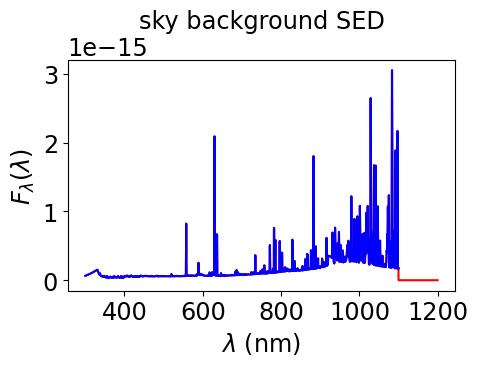

In [18]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

## Chose a Standard atmosphere

In [19]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.0# Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [20]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2023_44/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

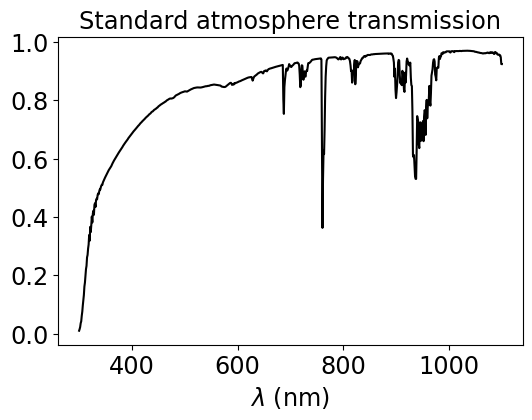

In [21]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

## Pickup an SED

In [22]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [23]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['stars' ,'white_dwarf'] 
sedtypes_not_used = ['sn','stars' ,'white_dwarf','galaxies', 'photoZ_outliers' ,'quasar']
sedtypes = sedtypes 

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [24]:
df_SED=df_SED.set_index('name')
df_SED

type
name                           
km10_7250.fits_g45        stars
km10_5250.fits_g45        stars
km10_6000.fits_g45        stars
km10_6500.fits_g45        stars
km10_4500.fits_g45        stars
wd_H_100000_80      white_dwarf
wd_He_5500_80       white_dwarf
wd_H_5500_80        white_dwarf
wd_H_50000_80       white_dwarf
wd_H_15000_80       white_dwarf
wd_He_10000_80      white_dwarf
wd_He_15000_80      white_dwarf

In [25]:
renorm_mag_inZ = 10

all_selected_sed = []
all_tag_sed = []

for key in df_SED.index:
  
    
    the_sed = copy.deepcopy(seds[key])
       
    flux_norm = the_sed.calc_flux_norm(renorm_mag_inZ, pc.bandpass_total_std['z'])
    the_sed.multiply_flux_norm(flux_norm)
        
    the_sed_name = key
    all_selected_sed.append(the_sed)
    all_tag_sed.append(the_sed_name)
          

In [26]:
sed_flat = Sed()
sed_flat.set_flat_sed()
flux_norm = sed_flat.calc_flux_norm(renorm_mag_inZ , pc.bandpass_total_std['z'])
sed_flat.multiply_flux_norm(flux_norm)

all_selected_sed.append(sed_flat) 
all_tag_sed.append('flat')

In [27]:
NSEDSEL = len(all_selected_sed)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSEDSEL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEDSEL), alpha=1)

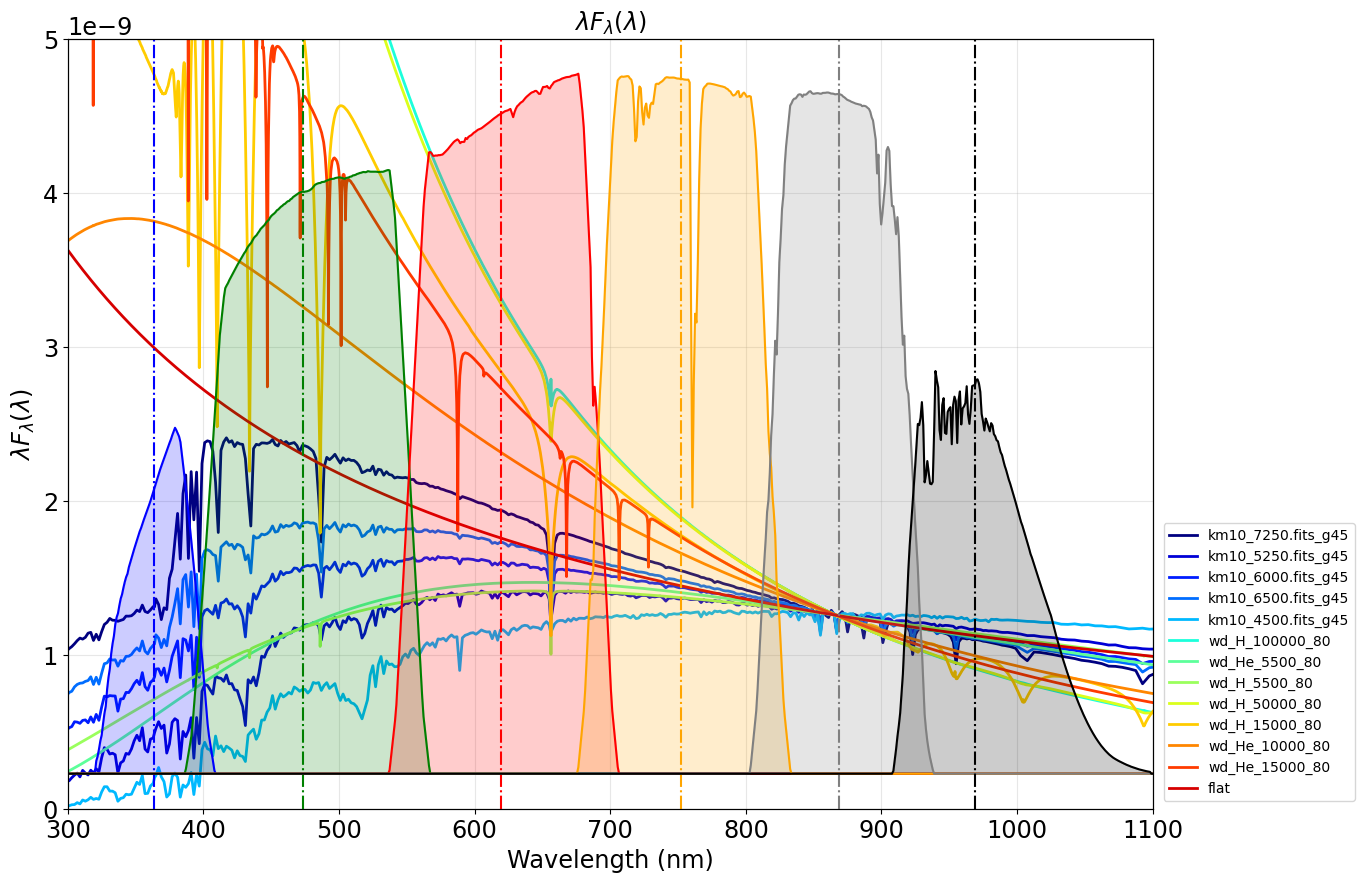

In [28]:
fig, ax = plt.subplots(1,1,figsize=(14,10))
all_flmax = np.zeros(NSEDSEL)


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    ax.plot(the_sed.wavelen, the_sed.flambda * the_sed.wavelen,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=2)
    #idx_inrange = np.where(np.logical_and(the_sed.flambda>=WLMIN, the_sed.flambda<WLMAX))[0]
    #flinrange = (the_sed.flambda * the_sed.wavelen)[idx_inrange]
    #all_flmax[idx] = np.max(flinrange)
    
ax.set_ylim(0,5e-9)    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("$\lambda F_\lambda(\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])

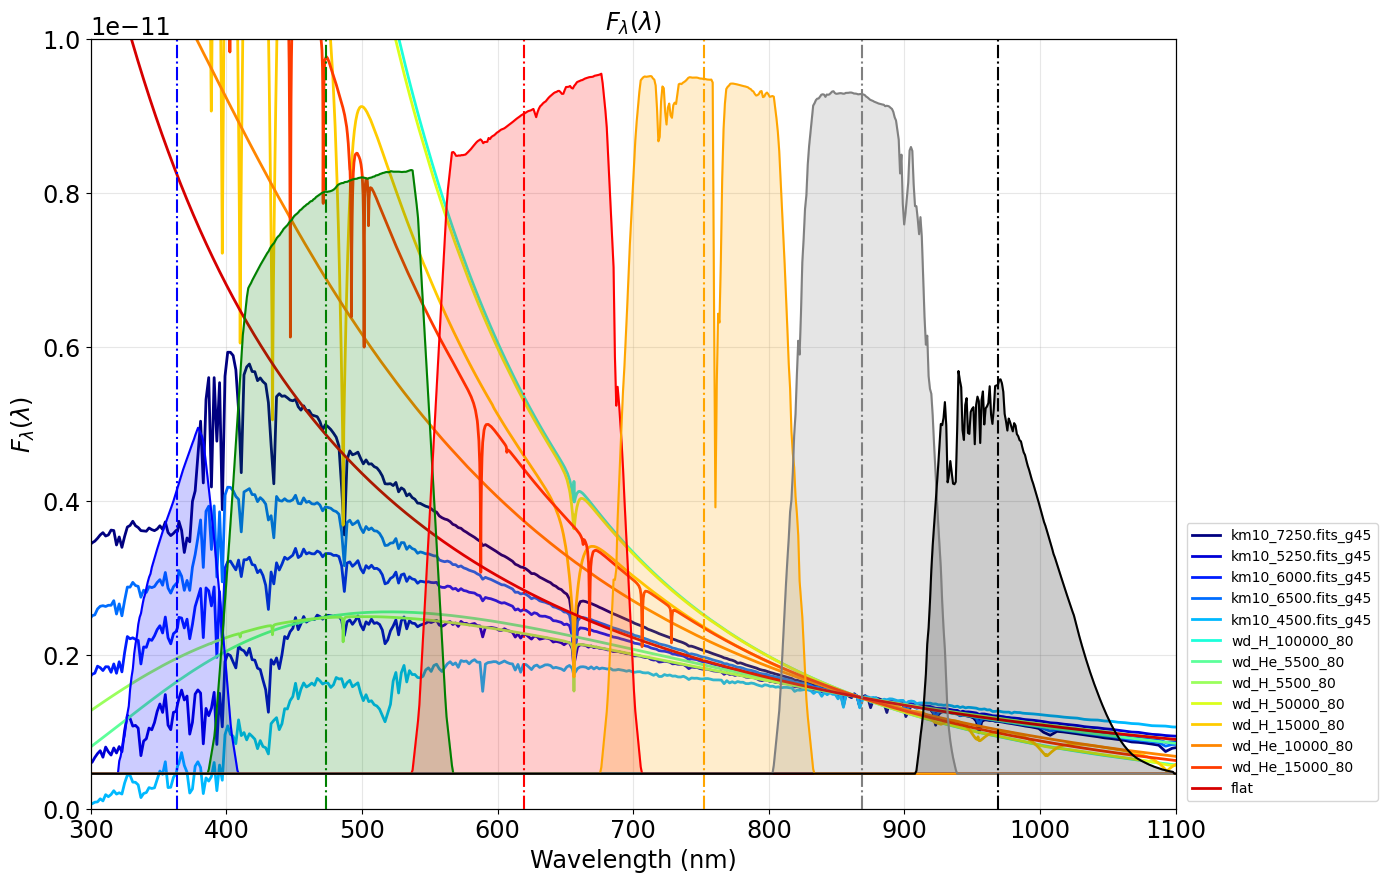

In [29]:
fig, ax = plt.subplots(1,1,figsize=(14,10))


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    ax.plot(the_sed.wavelen, the_sed.flambda ,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=2)
    #idx_inrange = np.where(np.logical_and(the_sed.flambda>=WLMIN, the_sed.flambda<WLMAX))[0]
    #flinrange = (the_sed.flambda * the_sed.wavelen)[idx_inrange]
    #all_flmax[idx] = np.max(flinrange)

    
ax.set_ylim(0,1e-11)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\lambda(\lambda)$")
ax.set_title("$F_\lambda (\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

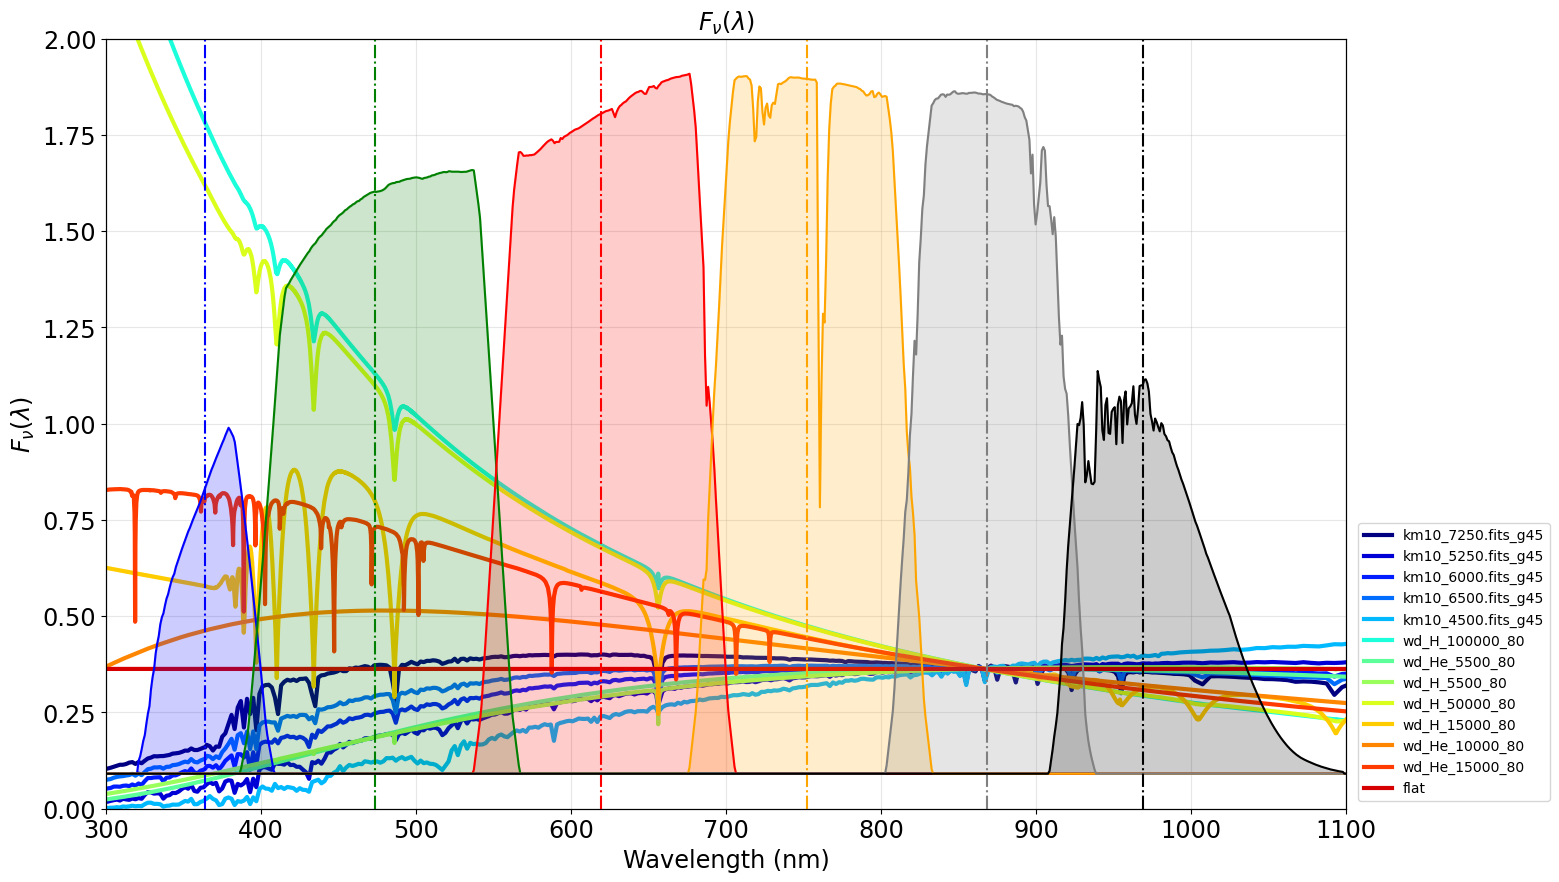

In [30]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(16,10))
for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    wavel,fnu = the_sed.get_sed_fnu()
    ax.plot(wavel, fnu,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=3)


ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])
ax.set_ylim(0,2e0)
                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

# Usefull photometric values from rubin_sim

In [31]:
photoparams = set_photometric_parameters(15, 2 , readnoise=None)

In [32]:
# constant in zero point
F0AB = 3631*(1*u.Jy).cgs.value
Z0PTconst = 2.5*np.log10((F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime)/(photoparams.gain*const.h.cgs.value))

z0pt_std= {}
for index,f in enumerate(filter_tagnames):
    z0pt_std[f] = Z0PTconst + 2.5*np.log10(pc.all_II0_std[f])
pd.DataFrame(z0pt_std, index=["z0pt_std"]).T    

z0pt_std
u  29.723683
g  31.132372
r  30.927937
i  30.637975
z  30.240657
y  29.446766

# Fit

## Fit gaussian process

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [34]:
FILTERWL

array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

In [35]:
wl0 = FILTERWL[:,2]
wl0

array([363.59690349, 473.54069923, 619.49926767, 752.01084117,
       868.488419  , 969.10570859])

In [36]:
index = 0
the_sed = all_selected_sed[index]
the_sed_name = os.path.basename(the_sed.name)
wavel,fnu = the_sed.get_sed_fnu()

In [37]:
func = interpolate.interp1d(wavel,fnu)
fl0=func(wl0)

In [38]:
def FitGaussianProcess(wl0,fl0,wlfit,scale=10.,scalemin=1.,scalemax=5000.):
    """
    Fit a gaussian process on SED

    Parameter:
      wl0 : wavelength points
      fl0 : flux points
      wlfit : wavelenth over which fit results are evaluated
      scale : kernel scale length (hyper parameter)
      scalemin,scalemax boundaries of scale
    """

    kernel = 1 * RBF(length_scale=scale, length_scale_bounds=(scalemin, scalemax))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    X_train = wl0[:,np.newaxis]
    X= wlfit[:,np.newaxis]
    y_train = fl0
    gaussian_process.fit(X_train, y_train)
    mean_prediction = gaussian_process.predict(X, return_std=False)
    return mean_prediction

In [39]:
yfit = FitGaussianProcess(wl0,fl0,wlfit=wavel)

In [40]:
the_sed_approx = Sed(wavelen=wavel, fnu=yfit, name="fGP_"+the_sed_name)
wls,fls = the_sed_approx.get_sed_fnu()

In [41]:
mag_true = {}
mag_approx = {}
mag_diff = {}

for index,f in enumerate(filter_tagnames):
    mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
    mag_approx[f] = the_sed_approx.calc_mag(pc.bandpass_total_std[f])
    mag_diff[f] = mag_true[f] - mag_approx[f]
    

In [42]:
mag_true

{'u': 10.736551179690997,
 'g': 10.014278581923083,
 'r': 9.907483204669981,
 'i': 9.930698615033064,
 'z': 10.0,
 'y': 10.041227586646572}

In [43]:
mag_approx

{'u': 10.862641119026101,
 'g': 10.010685817948444,
 'r': 9.893206705314837,
 'i': 9.933789042396647,
 'z': 10.01246246206266,
 'y': 10.017706461618104}

In [44]:
mag_diff

{'u': -0.12608993933510426,
 'g': 0.003592763974639368,
 'r': 0.014276499355144523,
 'i': -0.0030904273635830037,
 'z': -0.01246246206265944,
 'y': 0.02352112502846815}

In [45]:
mag_diff.values()

dict_values([-0.12608993933510426, 0.003592763974639368, 0.014276499355144523, -0.0030904273635830037, -0.01246246206265944, 0.02352112502846815])

In [46]:
np.array(list(mag_diff.values()))[:,np.newaxis]

array([[-0.12608994],
       [ 0.00359276],
       [ 0.0142765 ],
       [-0.00309043],
       [-0.01246246],
       [ 0.02352113]])

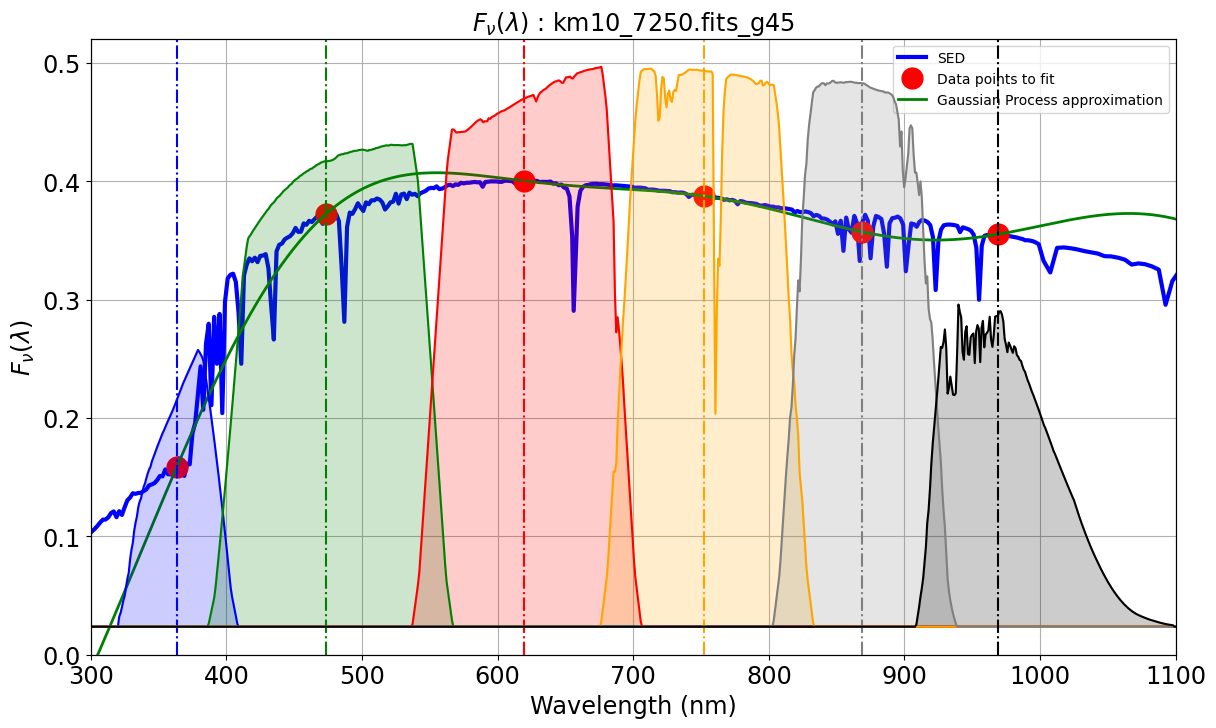

In [47]:
fig, ax = plt.subplots(1,1,figsize=(14,8))
ax.plot(wavel,fnu,'b-',lw=3,label="SED")
ax.plot(wl0,fl0,marker="o",color="r",ms=15,lw=0,label="Data points to fit")
ax.plot(wavel,yfit,'g-',lw=2,label="Gaussian Process approximation")
ax.grid()
ax.set_xlim(300, 1100)
ymin=0
ymax = fl0.max()*1.3
ax.set_ylim(ymin,ymax)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$"+ f" : {the_sed_name}")
ax.legend(loc="upper right")


ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])

------------------------------------------------------------------
km10_7250.fits_g45
{'u': -0.1260899407263878, 'g': 0.0035927643383377728, 'r': 0.014276499057560343, 'i': -0.003090427198886303, 'z': -0.012462462248356232, 'y': 0.02352112812590157}


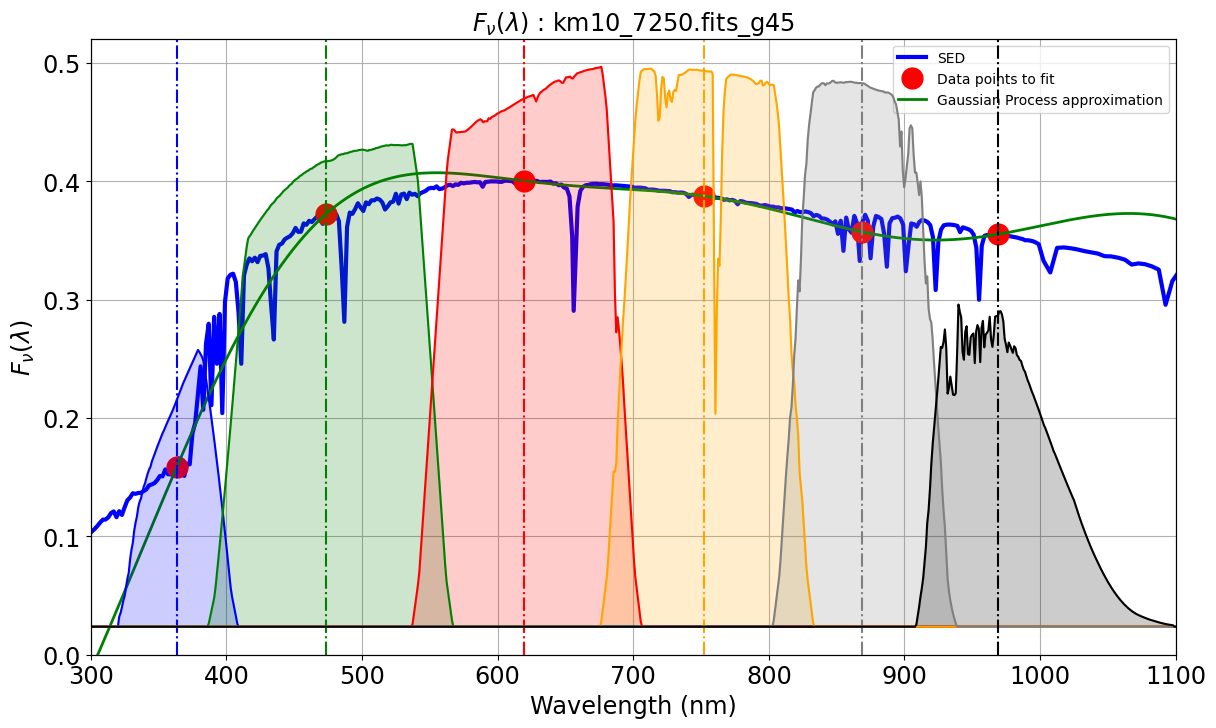

------------------------------------------------------------------
km10_5250.fits_g45
{'u': 0.0818427190087263, 'g': 0.06818541766077679, 'r': 0.005615814828338728, 'i': -0.0036539622406213113, 'z': -0.027533823169894944, 'y': 0.012455902656698825}


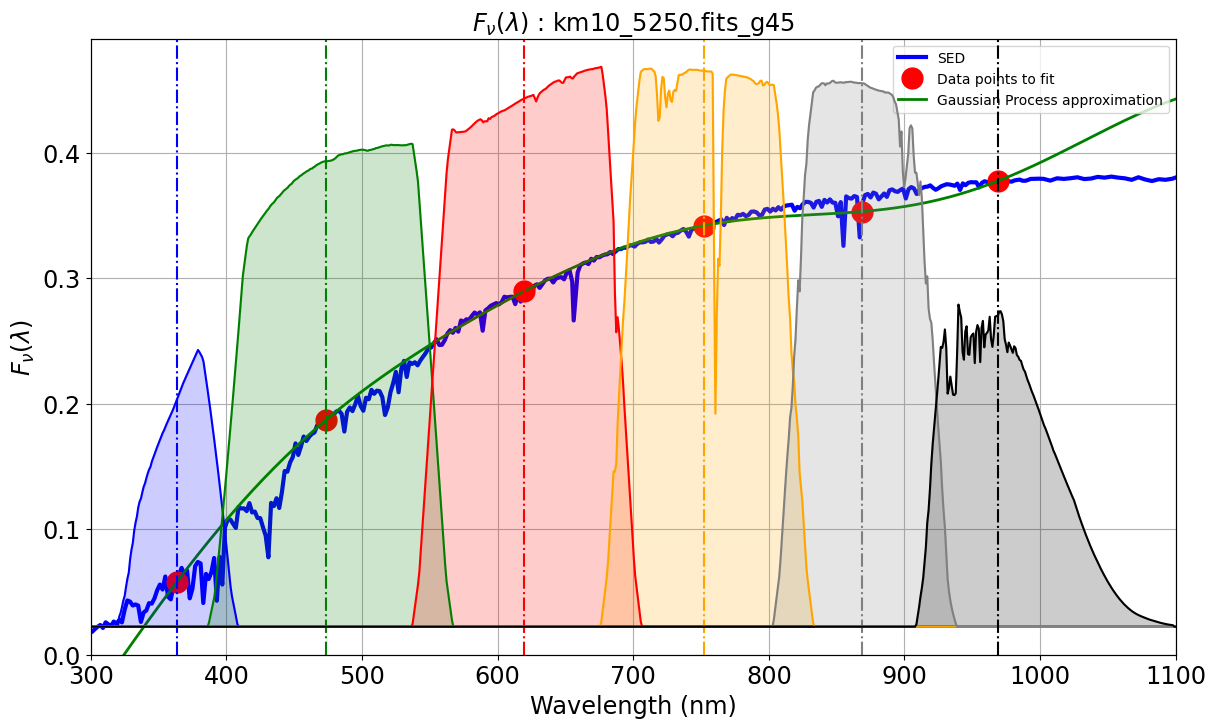

------------------------------------------------------------------
km10_6000.fits_g45
{'u': -0.03397819397175006, 'g': 0.028537489666133453, 'r': 0.007912251550996174, 'i': -0.002764100738794184, 'z': -0.017491450878956982, 'y': 0.012269134036008822}


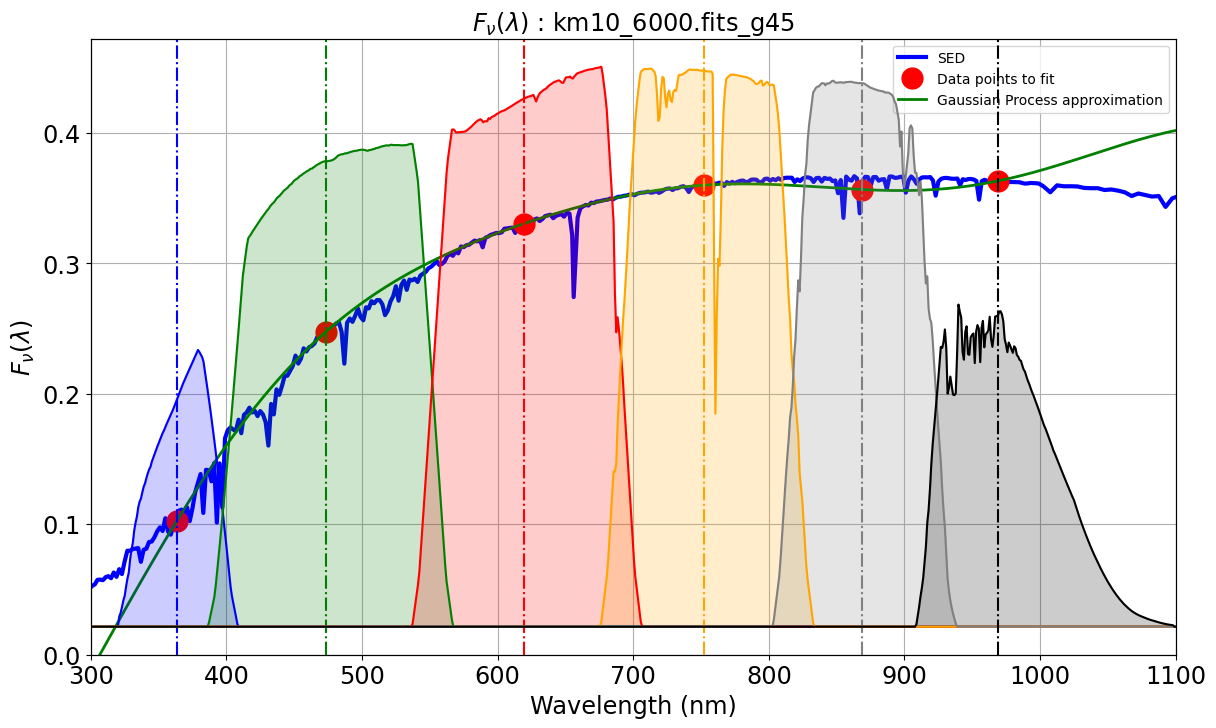

------------------------------------------------------------------
km10_6500.fits_g45
{'u': -0.07520347601294475, 'g': 0.013934350329522616, 'r': 0.010234946797677225, 'i': -0.002296544650084442, 'z': -0.014099459186272867, 'y': 0.014626810076148189}


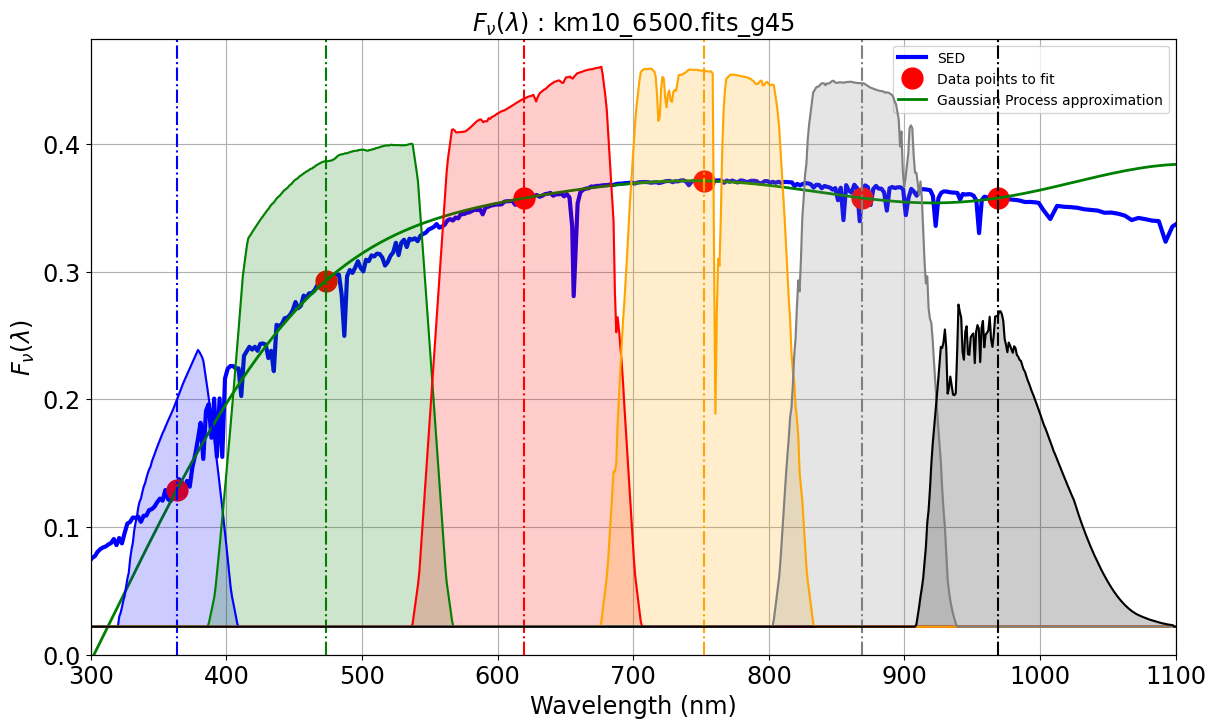

------------------------------------------------------------------
km10_4500.fits_g45
{'u': 0.2690859885456991, 'g': 0.1251380755149789, 'r': 0.00580731999875006, 'i': -0.0036299924977694076, 'z': -0.042687813963539156, 'y': 0.009533921239786025}


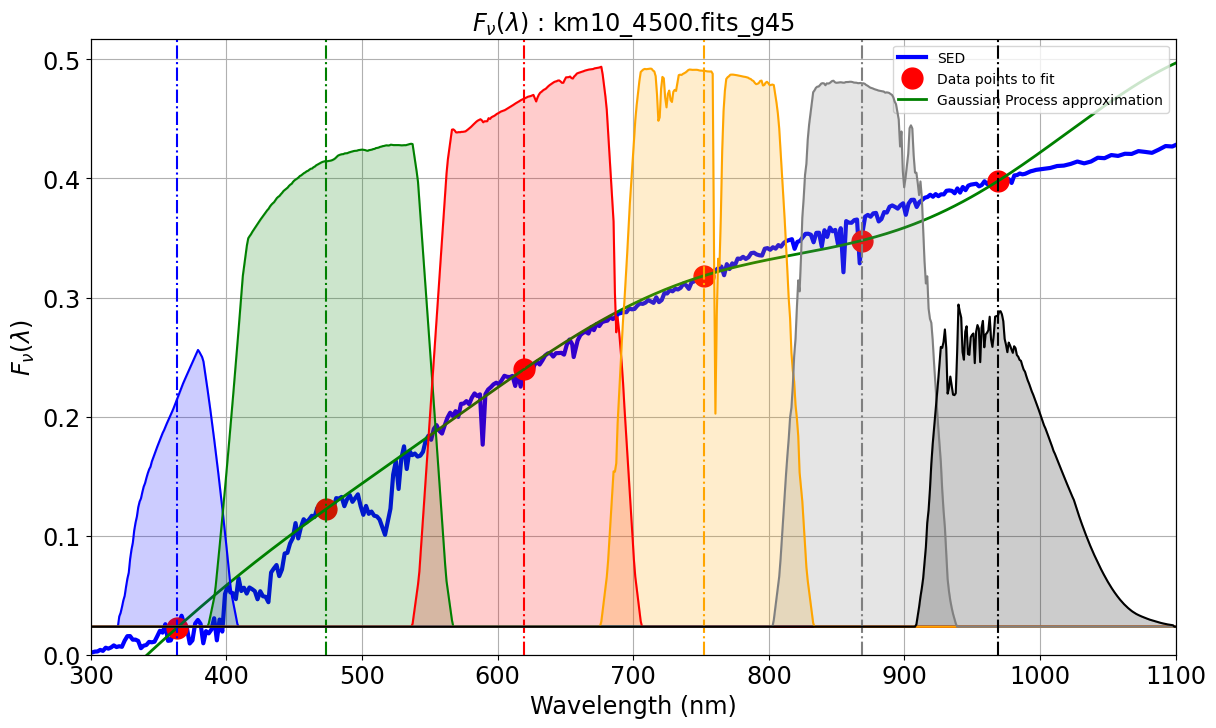

------------------------------------------------------------------
wd_H_100000_80.dat
{'u': -0.0027177243855831534, 'g': 0.00830328822580384, 'r': 0.0019384206957102634, 'i': -3.3647031951744566e-05, 'z': 0.00013087202670547526, 'y': -0.013791348130419934}


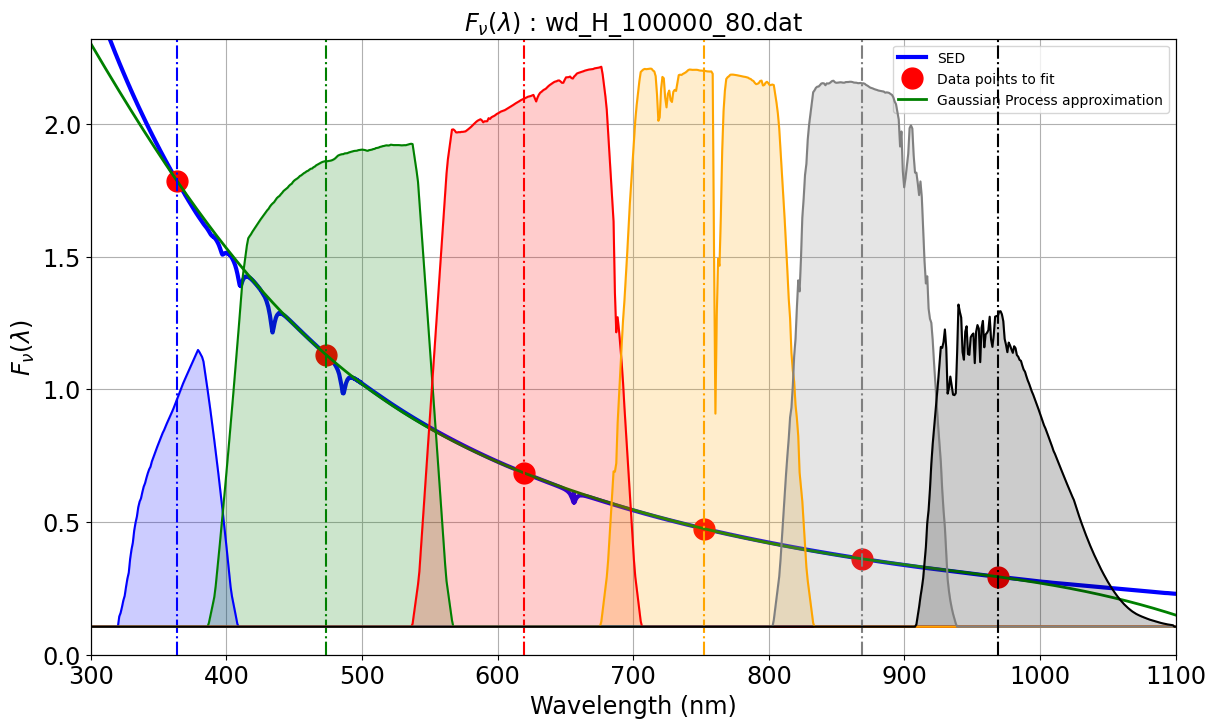

------------------------------------------------------------------
wd_He_5500_80.dat
{'u': -0.004885724166825867, 'g': 0.0008841393046754575, 'r': -0.00017976791921014978, 'i': -1.0143354298719487e-06, 'z': 7.658000132693132e-06, 'y': -0.0017004780403873099}


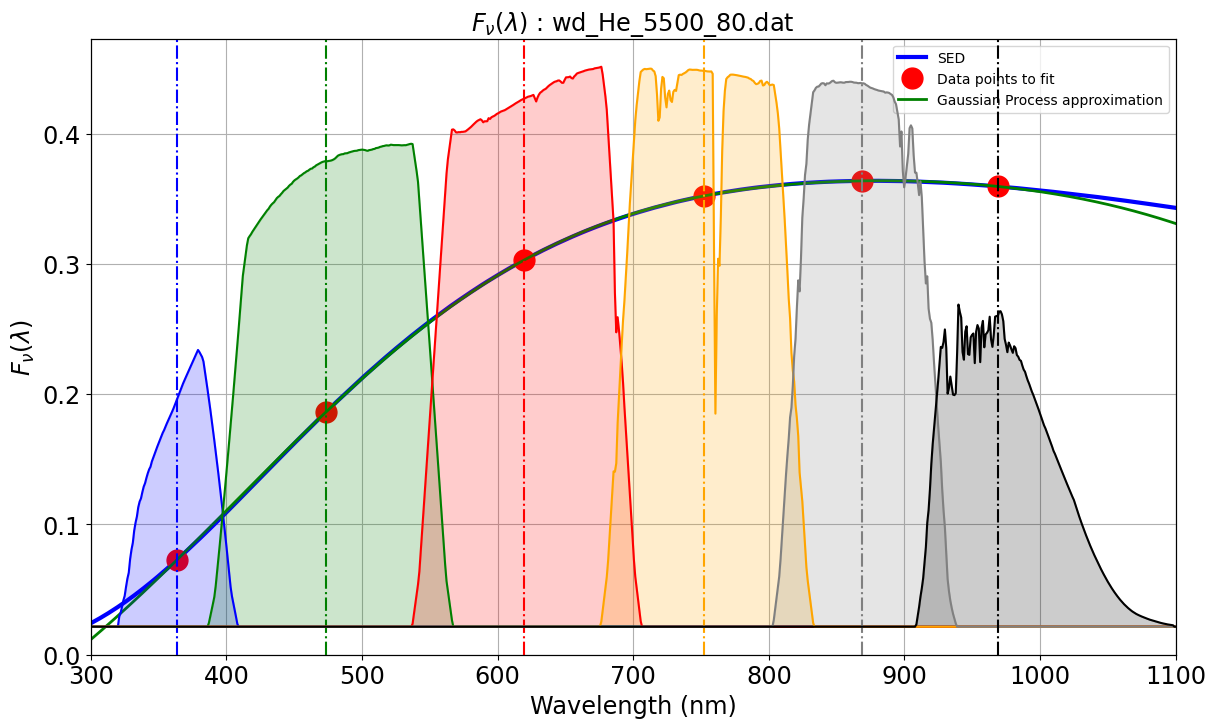

------------------------------------------------------------------
wd_H_5500_80.dat
{'u': -0.0021881392658418264, 'g': 0.001765188423522801, 'r': 0.0025468430632109573, 'i': -5.55669854307439e-05, 'z': -1.7281446007544332e-05, 'y': -0.0011530979229856797}


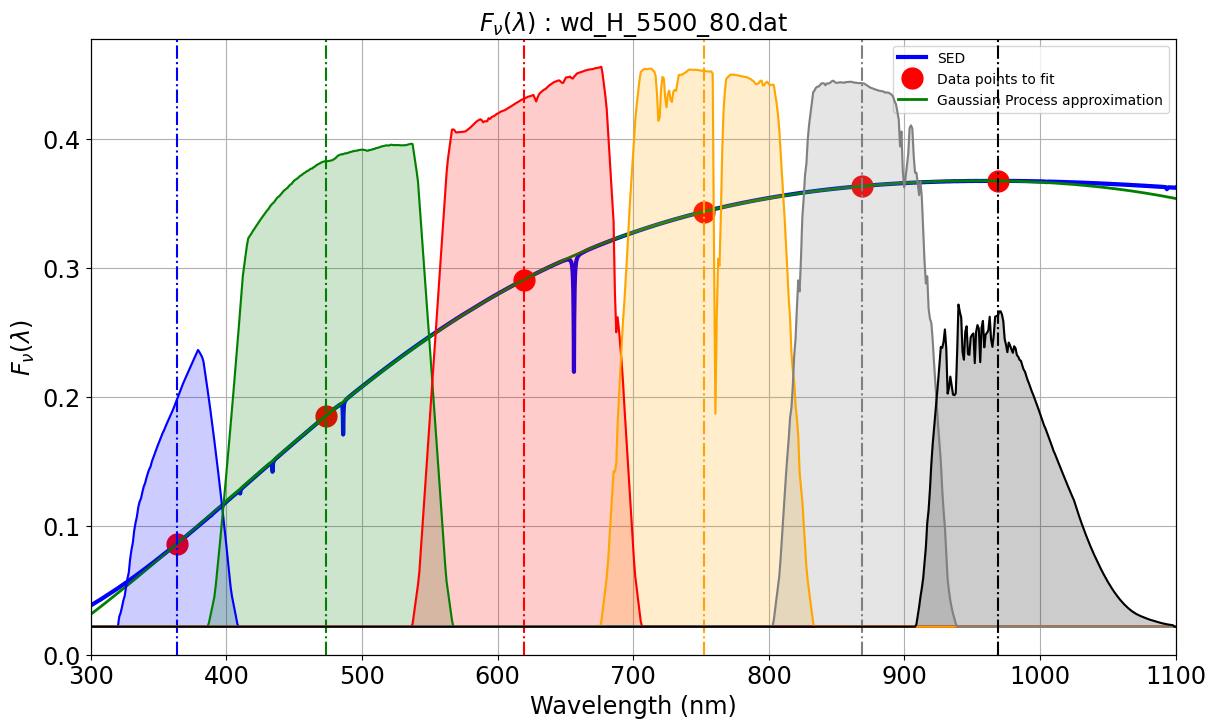

------------------------------------------------------------------
wd_H_50000_80.dat
{'u': -0.0019493391457459097, 'g': 0.01603491338653562, 'r': 0.006184390525756811, 'i': -0.00011472730395389874, 'z': -4.476792309660027e-05, 'y': 0.009561567048043784}


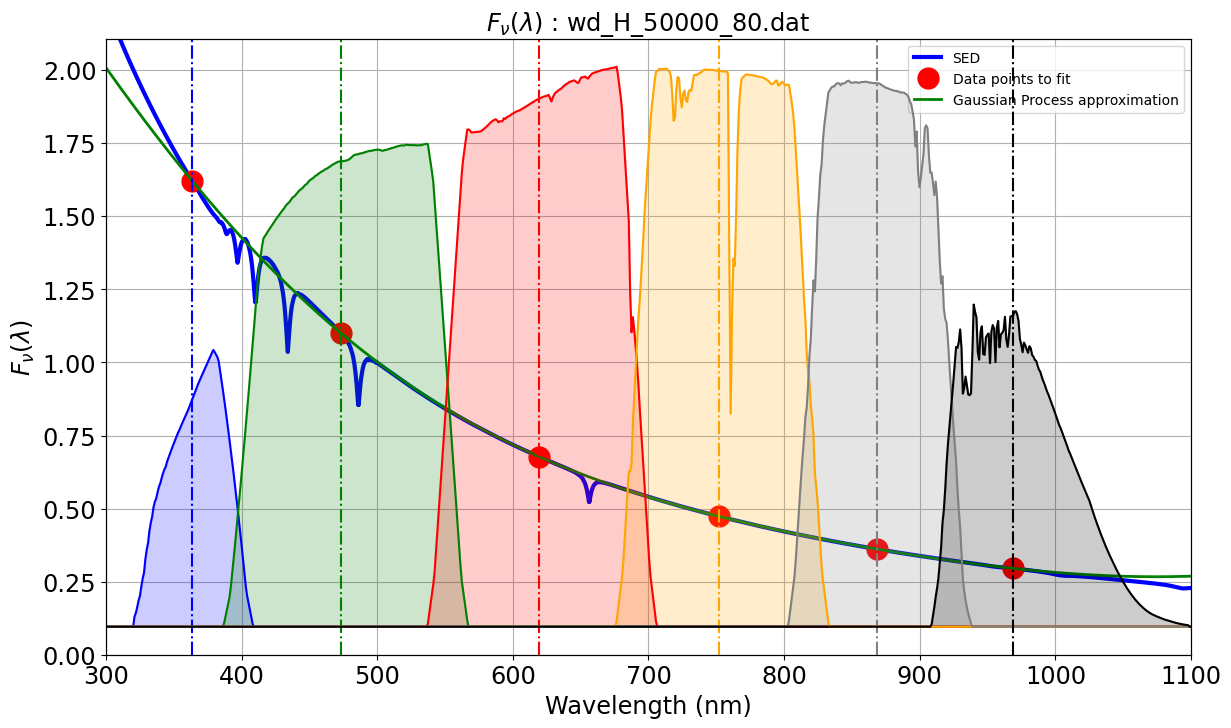

------------------------------------------------------------------
wd_H_15000_80.dat
{'u': -0.010108927879540985, 'g': 0.04637301266150473, 'r': 0.033527358522533746, 'i': -0.0021622565854215736, 'z': -0.0002163399674444122, 'y': 0.05307129293638013}


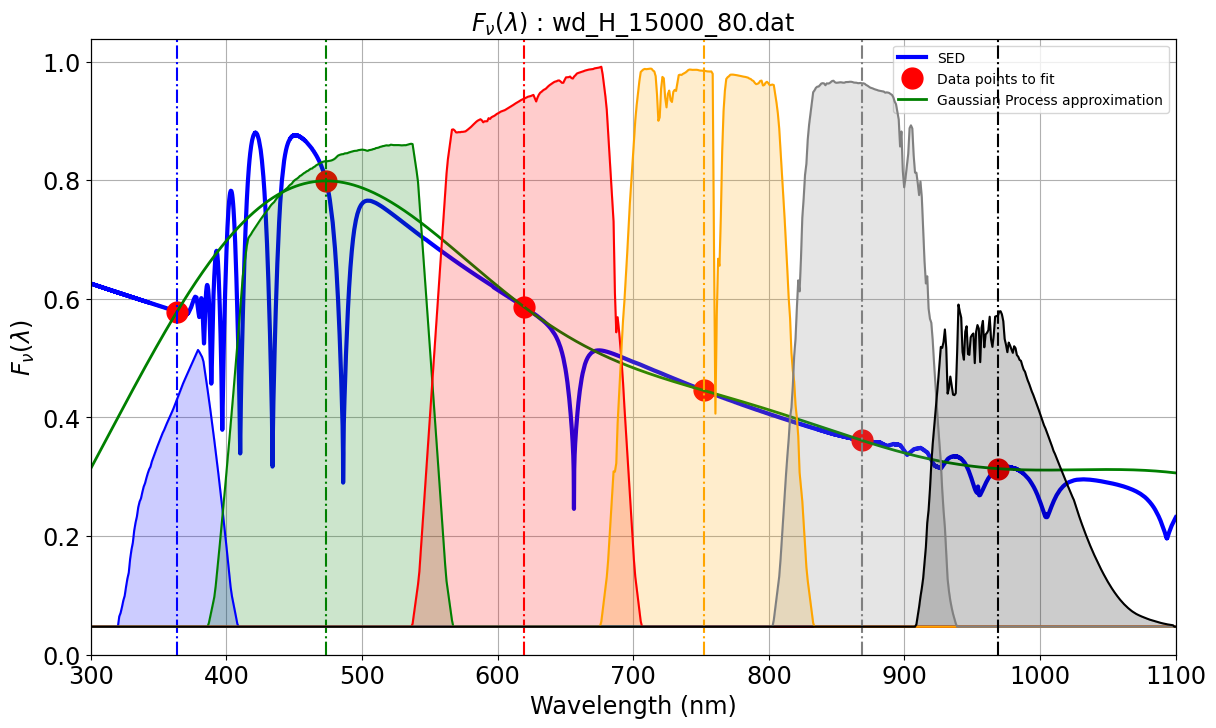

------------------------------------------------------------------
wd_He_10000_80.dat
{'u': 0.0011964336731882241, 'g': -0.0003896854641336489, 'r': 0.0001290647748284357, 'i': -2.231405319896851e-05, 'z': -6.566631517657129e-05, 'y': 0.00227393619692684}


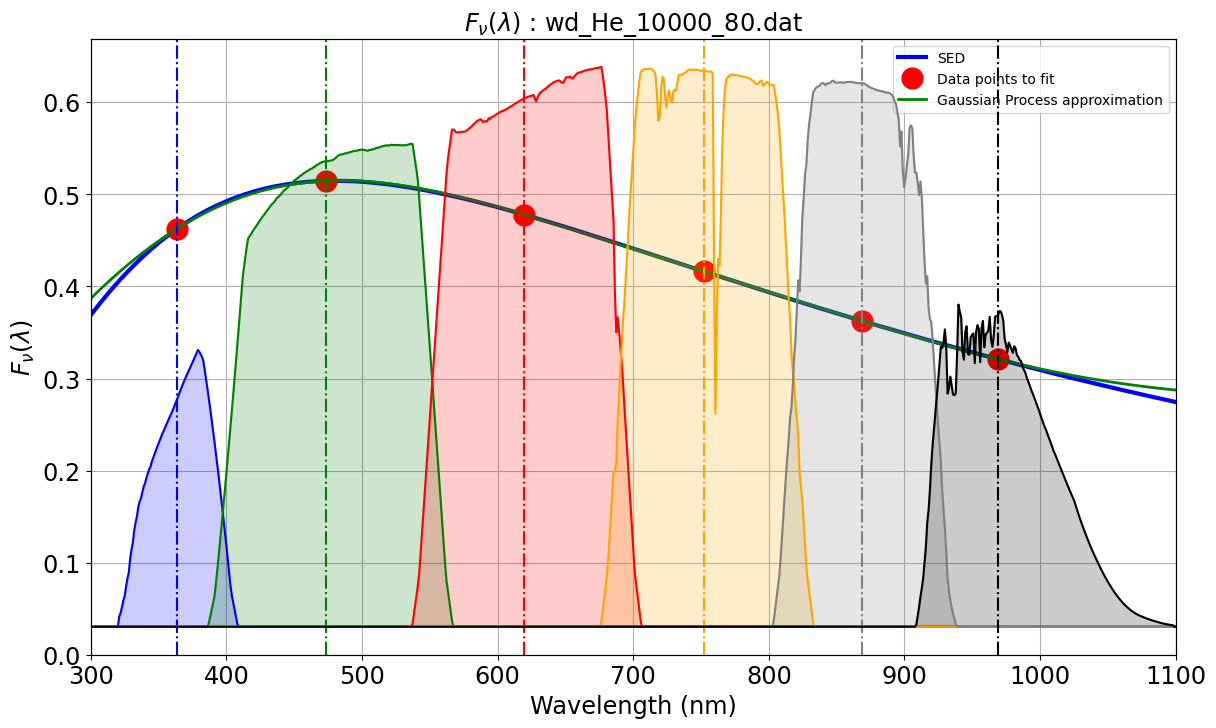

------------------------------------------------------------------
wd_He_15000_80.dat
{'u': -0.005744646833743872, 'g': 0.01234044198601758, 'r': 0.011565857953426573, 'i': 0.0050101701824072364, 'z': -0.0001752265808931952, 'y': 0.004881363131284289}


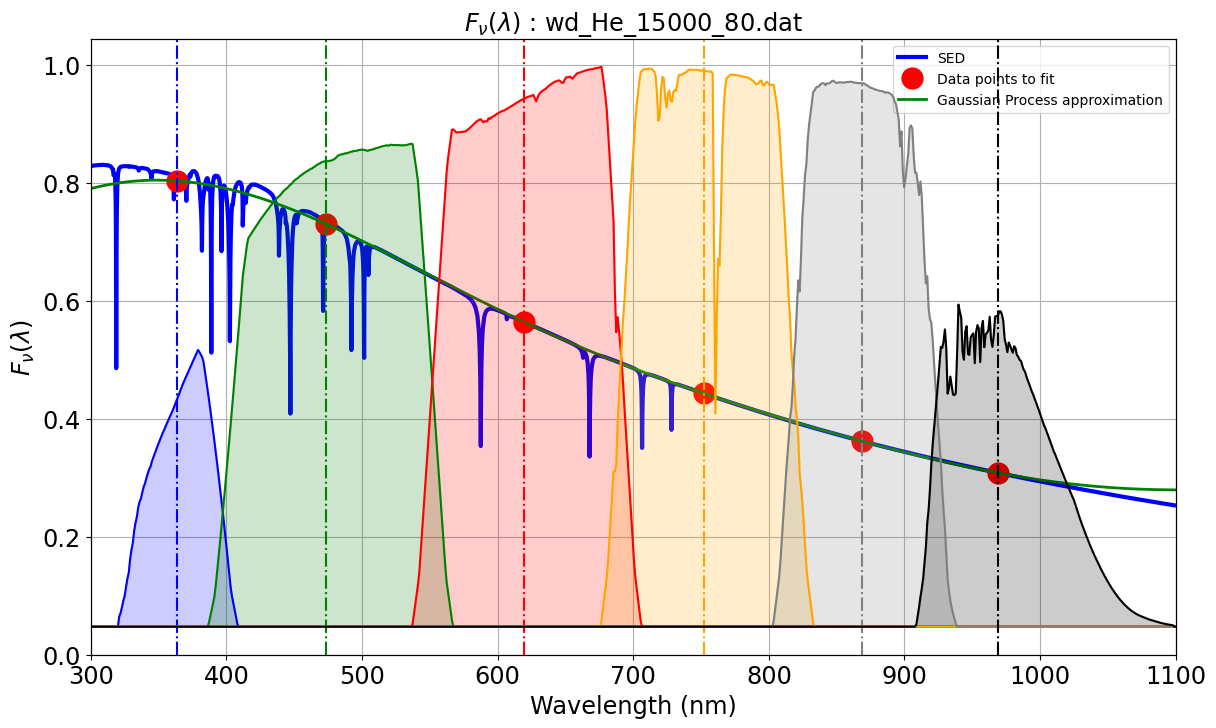

------------------------------------------------------------------
Flat
{'u': -3.9555825637194175e-07, 'g': 2.5186171548341463e-07, 'r': 9.109777288074383e-08, 'i': 1.339910884468054e-07, 'z': 2.4347375493505297e-07, 'y': -5.941312579693658e-07}


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


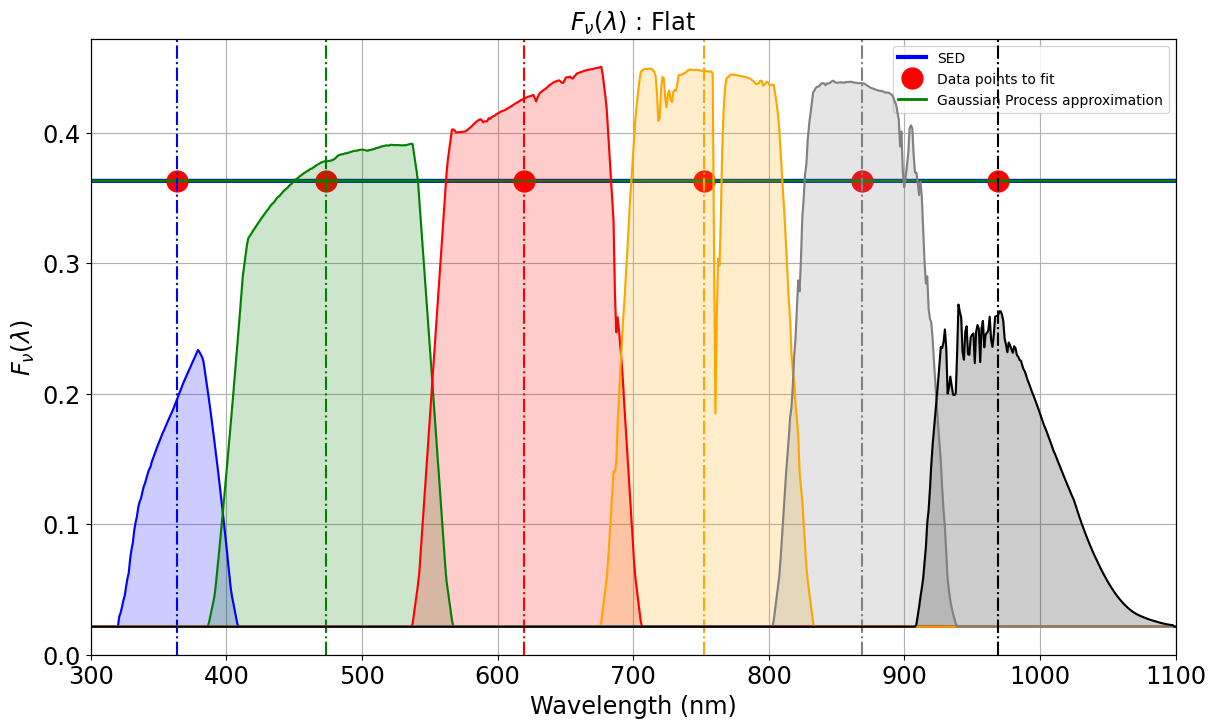

In [48]:
all_mag_true = []
all_mag_approx = []
all_mag_diff = []


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    the_sed_name = os.path.basename(the_sed.name)
    wavel,fnu = the_sed.get_sed_fnu()
    func = interpolate.interp1d(wavel,fnu)
    fl0=func(wl0)

    # does the fit
    yfit = FitGaussianProcess(wl0,fl0,wlfit=wavel)
    
    # calculate the approximated SED
    the_sed_approx = Sed(wavelen=wavel, fnu=yfit, name="fGP_"+the_sed_name)

    # calculate the magnitudes
    mag_true = {}
    mag_approx = {}
    mag_diff = {}
    for index,f in enumerate(filter_tagnames):
        mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
        mag_approx[f] = the_sed_approx.calc_mag(pc.bandpass_total_std[f])
        mag_diff[f] = mag_true[f] - mag_approx[f]
    print("------------------------------------------------------------------")
    print(the_sed_name)
    print(mag_diff)
    
    all_mag_true.append(mag_true)
    all_mag_approx.append(mag_approx)
    all_mag_diff.append(mag_diff)
    
    # plot
    fig, ax = plt.subplots(1,1,figsize=(14,8))
    ax.plot(wavel,fnu,'b-',lw=3,label="SED")
    ax.plot(wl0,fl0,marker="o",color="r",ms=15,lw=0,label="Data points to fit")
    ax.plot(wavel,yfit,'g-',lw=2,label="Gaussian Process approximation")
    ax.grid()
    ax.set_xlim(300, 1100)
    ymin=0
    ymax = fl0.max()*1.3
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("$F_\\nu (\lambda)$")
    ax.set_title("$F_\\nu (\lambda)$"+ f" : {the_sed_name}")
    ax.legend(loc="upper right")


    ax2 = ax.twinx()

    for index,f in enumerate(filter_tagnames):
    
        ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
        ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
        ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
        ax2.set_yticks([])

    plt.show()

## Fits a SED from chi2 minimisation on magnitudes

In [49]:
class FitSEDMags:
    """
    Class to fit magnitudes
    """
    def __init__(self,passband):
        
        print("Init FitSEDMags")
        self.passband = passband

    
    def func_residuals(self,params,*args):
        """
        This function is called by the scipy.optimize.least_squares function to compute the normalized residuals
        at each data point at each wavelength (yi-f(xi,thetaj)/sigmai
    
        input:
          - params : the unknown atmospheric parameters to fit (pwv,oz)
          - *args  : additionnal data provided to compute the mode : 
                 to the model
                   1) the wavelength array, 
                   2) flux data : the measured fluxes
                   3) dataerr : the error on fluxes
                   
                
        return:
          - the array of residuals for the given set of parameters required by the least_squares function 
        """

        #args=[xdata,ydata,yerrdata,wlrange]
        
        wlpoints = args[0]         # wavelength array required by the model function pred2 (x values) 
        mag_data = args[1]       # the observed mag array
        mag_dataerr = args[2]    # the error on the observed mag array
        wlrange = args[3]        # the wavelength range of the SED

        
        
        # cumpute the flux from the parameters
        flux_model = FitGaussianProcess(wlpoints,params,wlrange,scale=10.,scalemin=1.,scalemax=5000.)
        # compute the model mags
        the_sed_params = Sed(wavelen=wlrange, fnu=flux_model)

        residuals = {}
        mag_params = {}
        for index,f in enumerate(filter_tagnames):
            mag_params[f] = the_sed_params.calc_mag(pc.bandpass_total_std[f])
            residuals[f] = (mag_data[f] - mag_params[f])/mag_dataerr[f]  
        
        res = np.array(list(residuals.values()))
      
        
        return res


    def fit(self,params0,bounds,xdata,ydata,yerrdata,wlrange):
        """
        Fit 

        """

        #print("params0",params0)
        #print("bounds",bounds)
        #print("xdata",xdata)
        #print("ydata",ydata)
        #print("yerrdata",yerrdata)
        #print("wlrange",wlrange,type(wlrange))
        
        res_fit = least_squares(self.func_residuals,params0,bounds=bounds,args=[xdata,ydata,yerrdata,wlrange])
        
       
    
        # results fo the fit
        popt= res_fit.x
        J = res_fit.jac
        pcov = np.linalg.inv(J.T.dot(J))
        sigmas = np.sqrt(np.diagonal(pcov))
        cost=res_fit.cost
        residuals = res_fit.fun
        chi2=np.sum(residuals**2)
        ndeg = J.shape[0]- popt.shape[0]
        chi2_per_deg = chi2/ndeg
        
        
        fit_dict = {"chi2":chi2,"ndeg":ndeg,"chi2_per_deg":chi2_per_deg,"popt":popt,"sigmas":sigmas}

        return res_fit,fit_dict

### Select the SED

In [50]:
the_sedflat = all_selected_sed[-1]

In [51]:
index = 0
the_sed = all_selected_sed[index]
the_sed_name = os.path.basename(the_sed.name)
wavel,fnu = the_sed.get_sed_fnu()

In [52]:
the_sed_name 

'km10_7250.fits_g45'

## initialize the fit object with the passband

In [53]:
the_fit = FitSEDMags(pc.bandpass_total_std)

Init FitSEDMags


In [54]:
mag_true = {}
mag_flat = {}

for index,f in enumerate(filter_tagnames):
    mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
    mag_flat[f] = the_sedflat.calc_mag(pc.bandpass_total_std[f])


In [55]:
mag_true_err = {"u": 0.01, "g": 0.01, "r": 0.01, "i": 0.01, "z": 0.01, "y": 0.01}

In [56]:
wavel_flat,fnu_flat = the_sedflat.get_sed_fnu()
func = interpolate.interp1d(wavel_flat,fnu_flat)
fl0=func(wl0)

In [57]:
params0 = fl0
bounds = (fl0/10.,fl0*10.)

In [58]:
bounds

(array([0.03631, 0.03631, 0.03631, 0.03631, 0.03631, 0.03631]),
 array([3.631, 3.631, 3.631, 3.631, 3.631, 3.631]))

In [59]:
xdata = wl0
ydata = mag_true
ydataerr = mag_true_err

res_fit,fit_dict = the_fit.fit(params0 = params0 ,bounds = bounds,xdata = xdata ,ydata = mag_true ,yerrdata=ydataerr,wlrange=wavel)


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parame

In [60]:
yfit = FitGaussianProcess(wl0,fit_dict["popt"],wlfit=wavel)

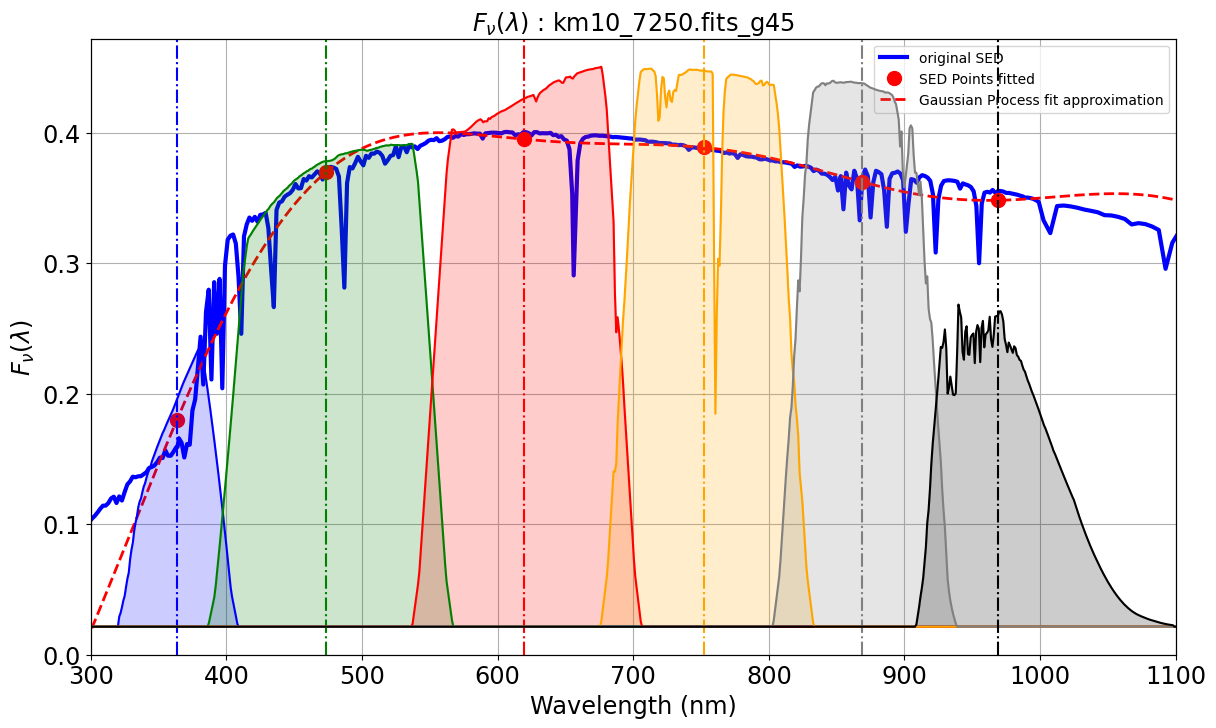

In [61]:
fig, ax = plt.subplots(1,1,figsize=(14,8))
ax.plot(wavel,fnu,'b-',lw=3,label="original SED")
ax.plot(wl0,fit_dict["popt"],marker="o",color="r",ms=10,lw=0,label="SED Points fitted")
ax.plot(wavel,yfit,'r--',lw=2,label="Gaussian Process fit approximation")
ax.grid()
ax.set_xlim(300, 1100)
ymin=0
ymax = fl0.max()*1.3
ax.set_ylim(ymin,ymax)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$"+ f" : {the_sed_name}")
ax.legend(loc="upper right")


ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified u

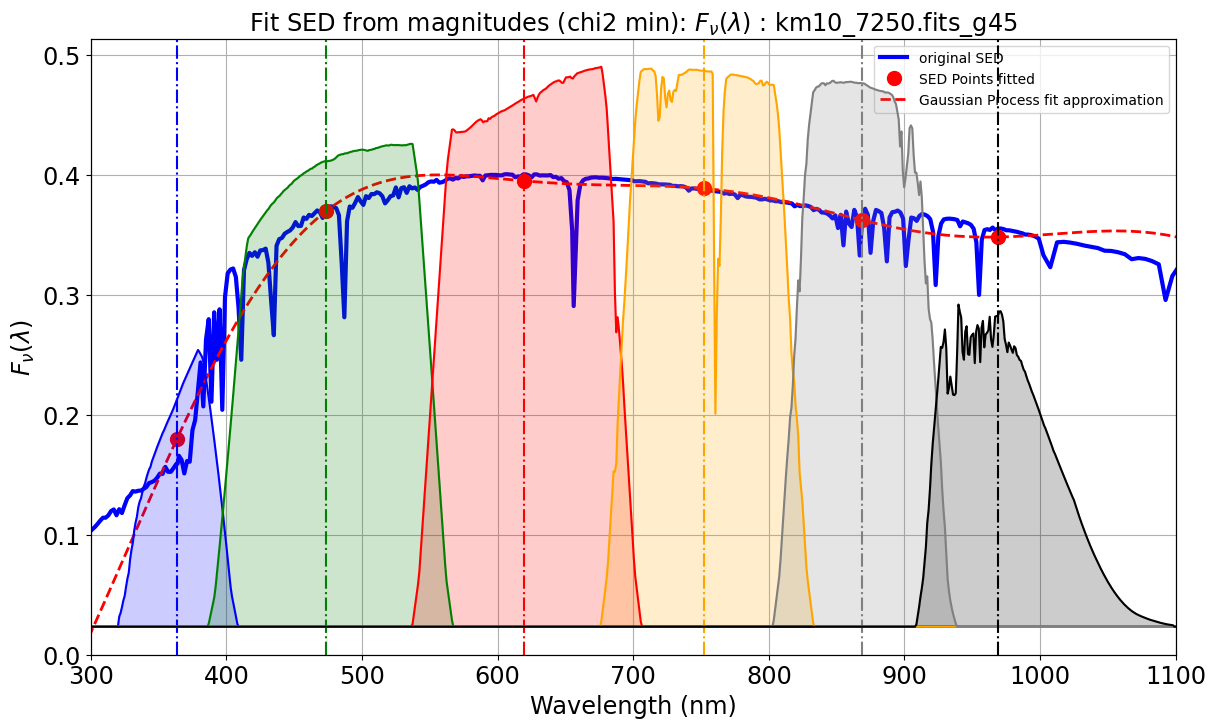

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parame

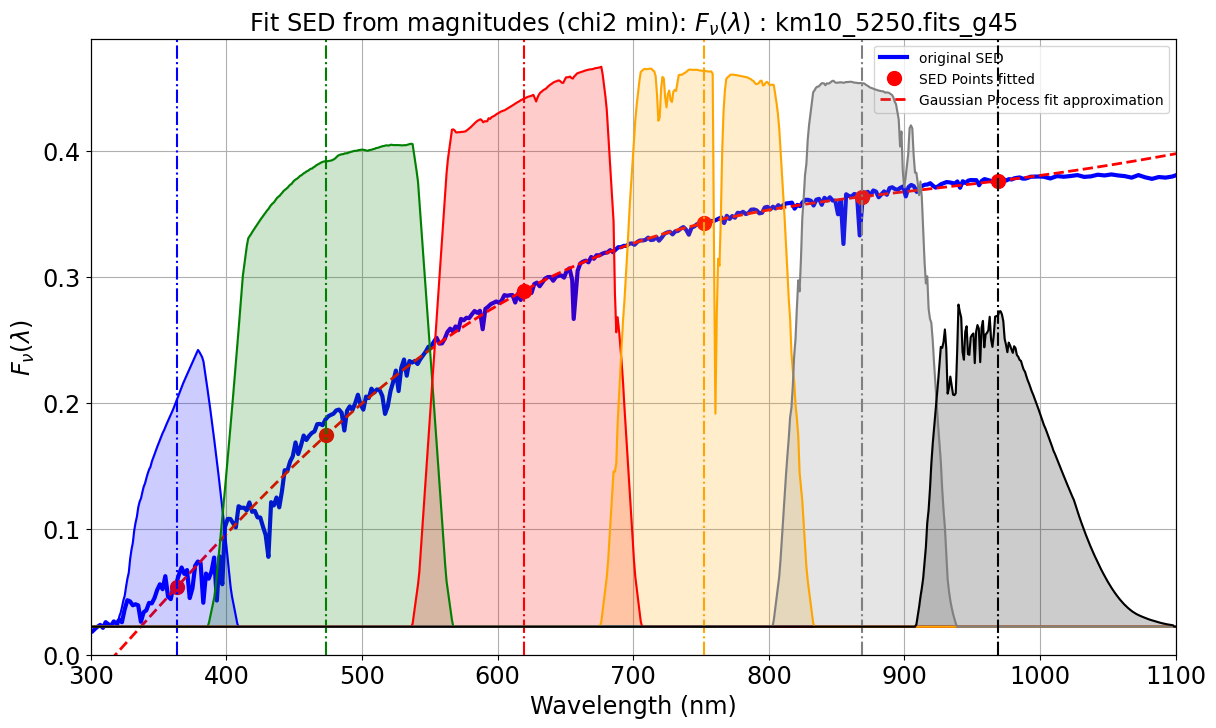

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parame

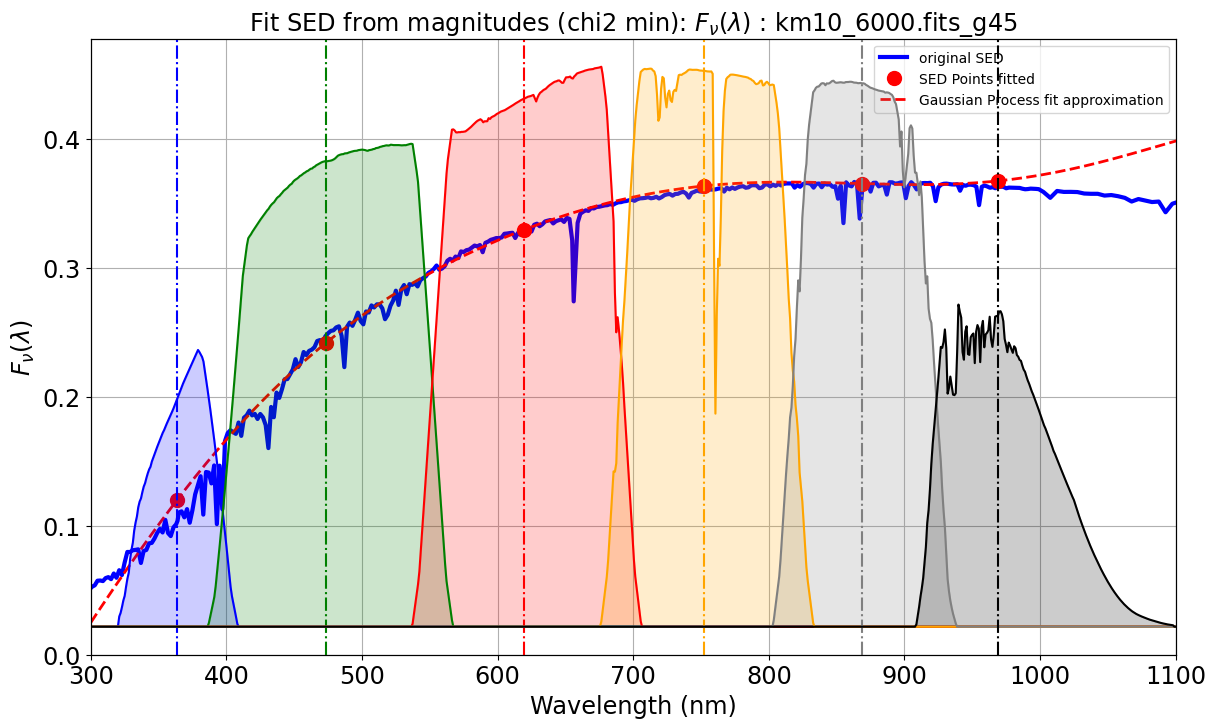

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified u

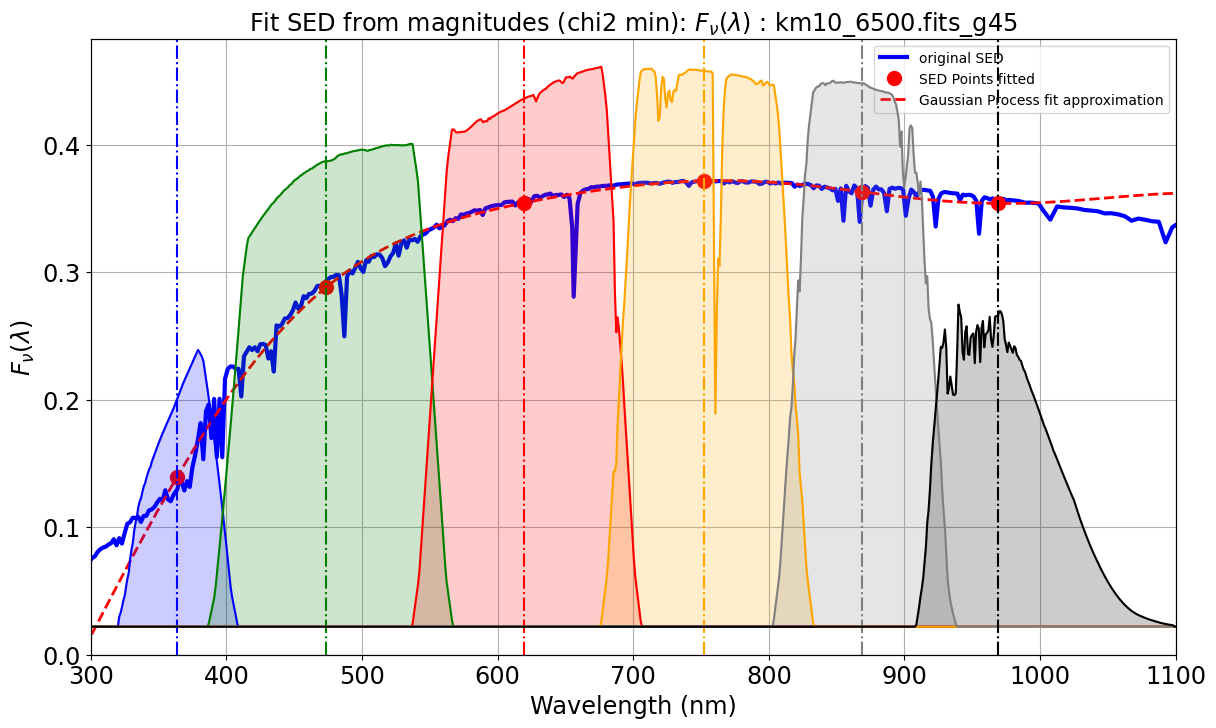

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parame

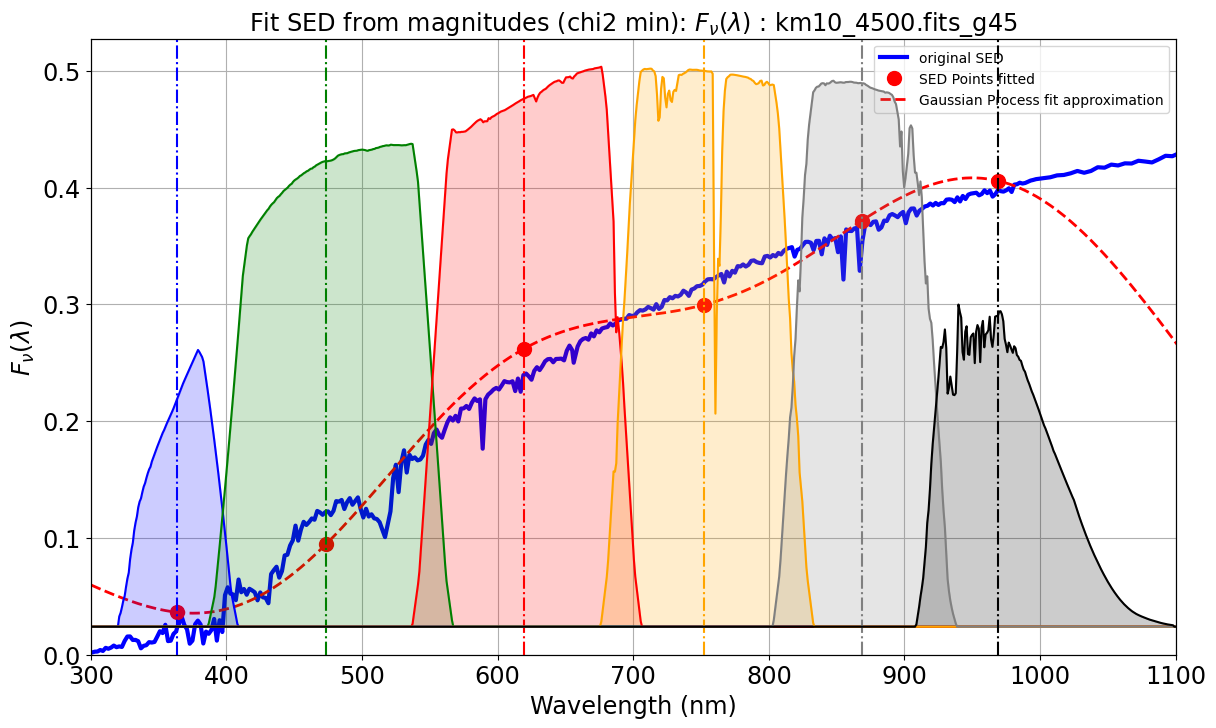

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parame

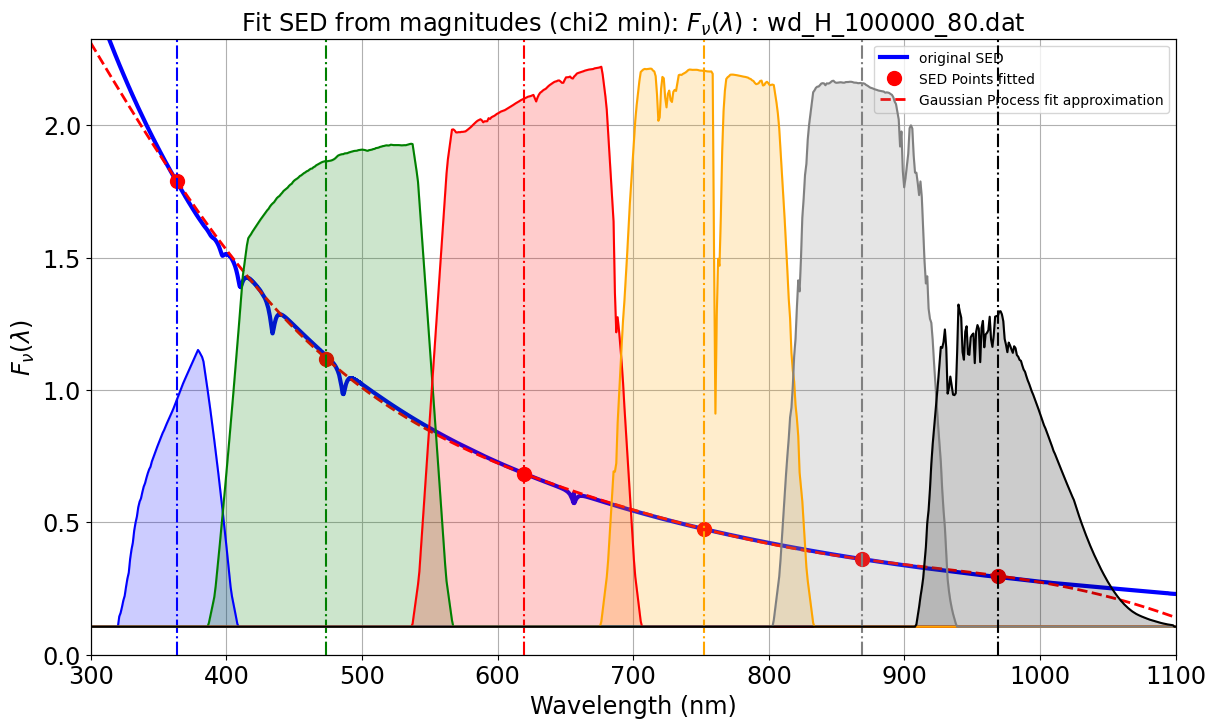

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterati

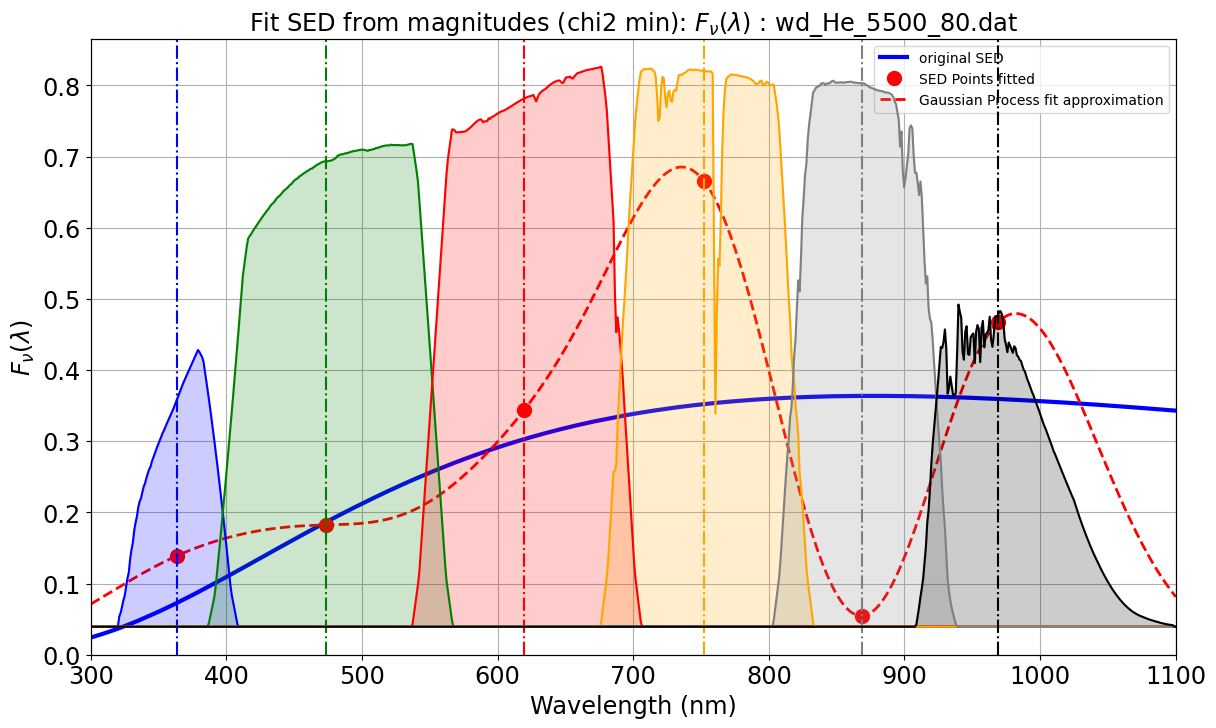

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified u

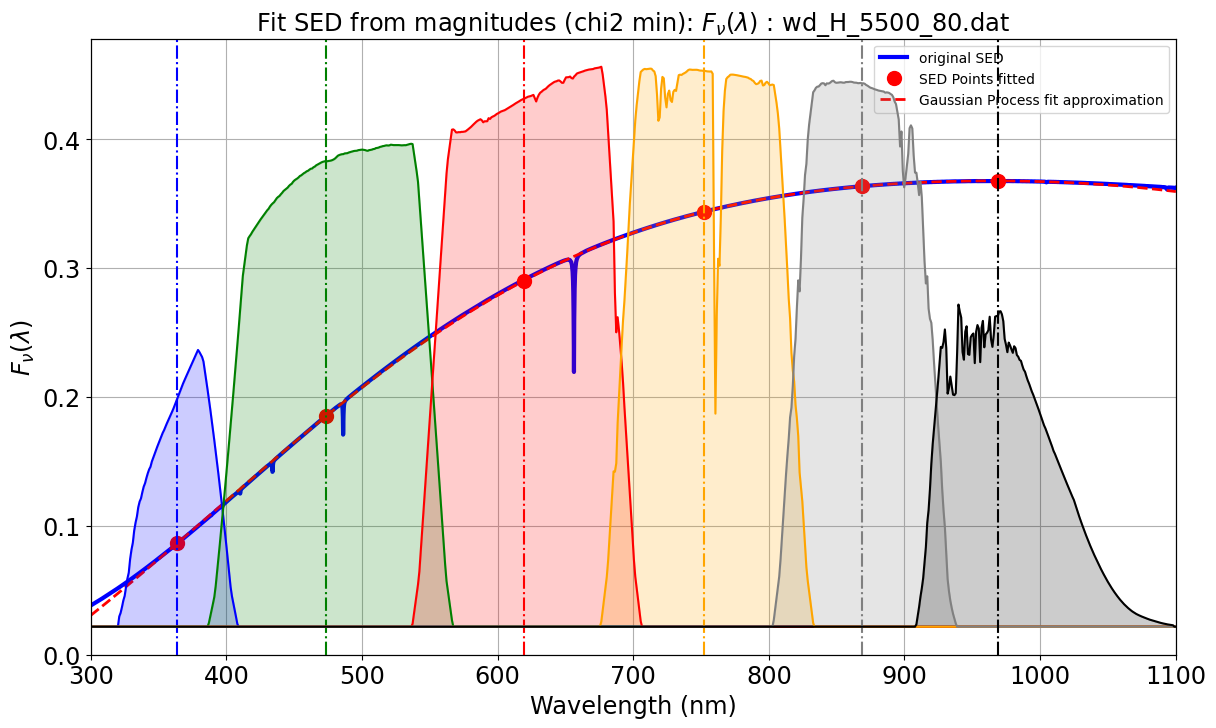

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified u

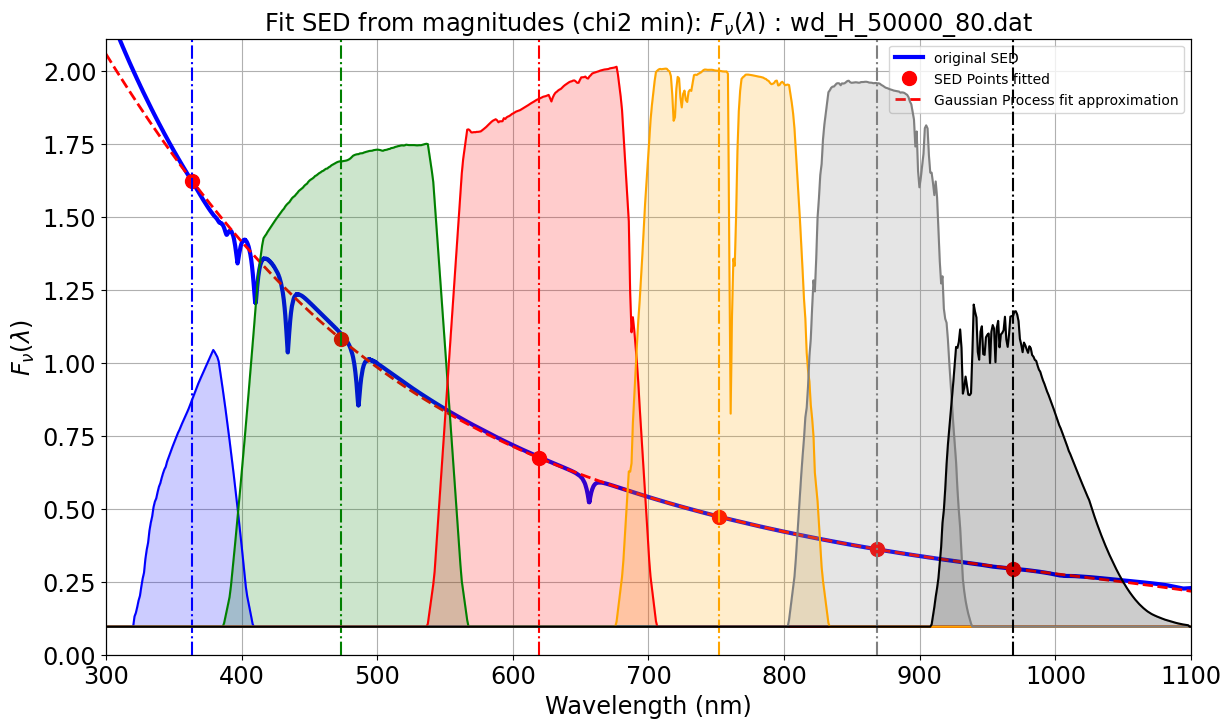

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified u

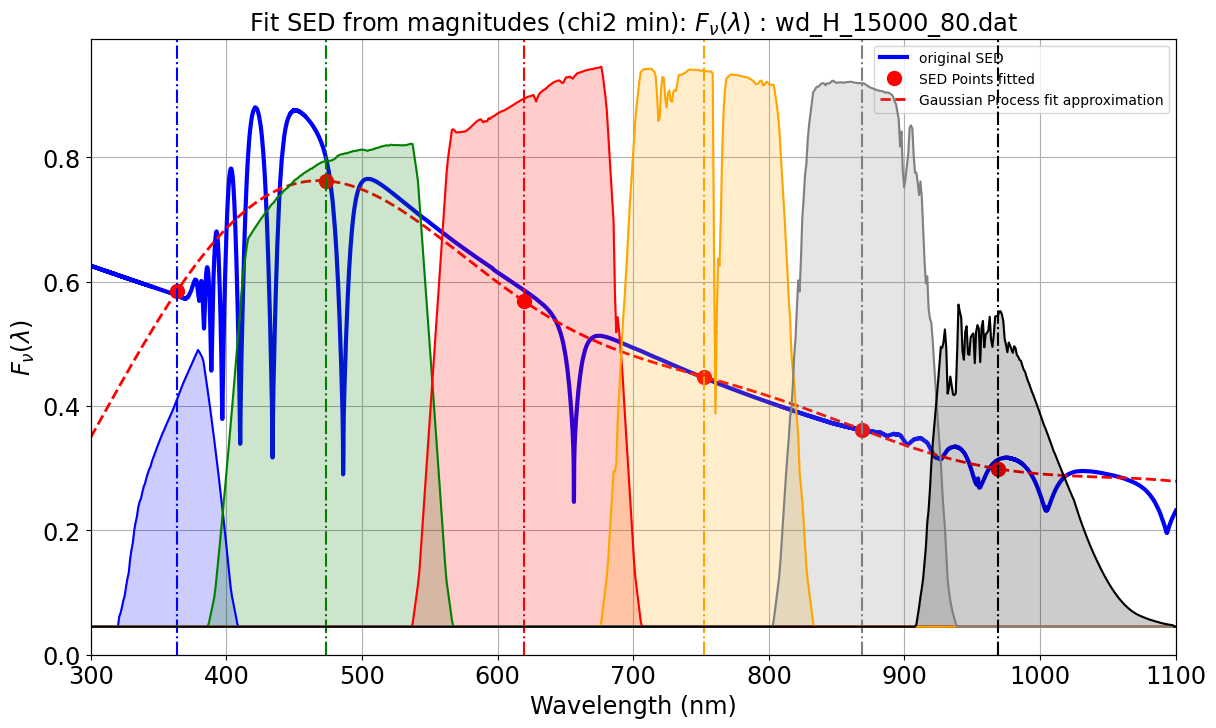

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterati

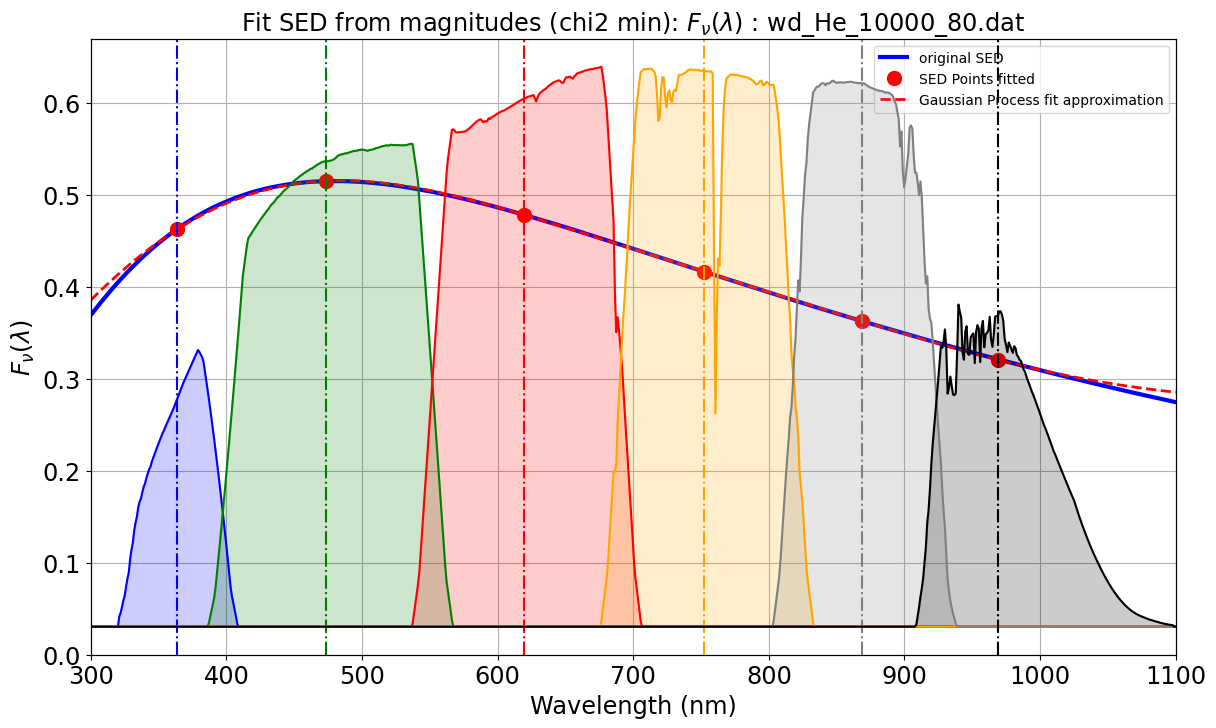

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified u

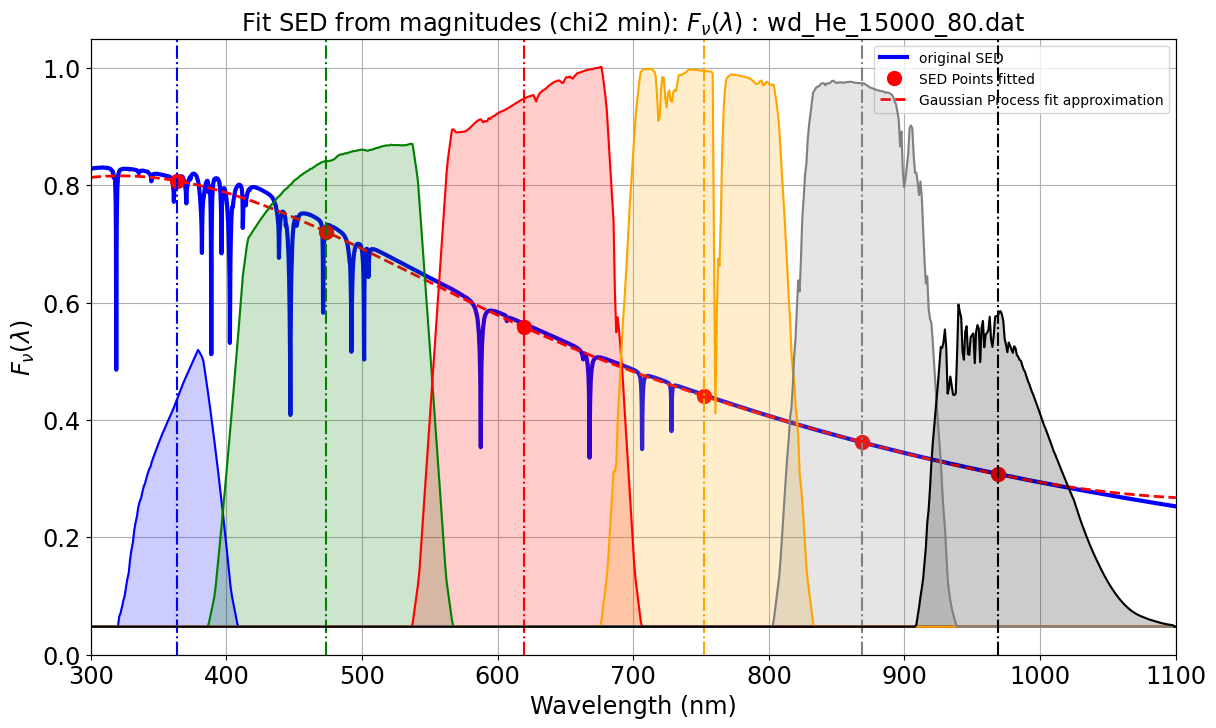

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 5000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parame

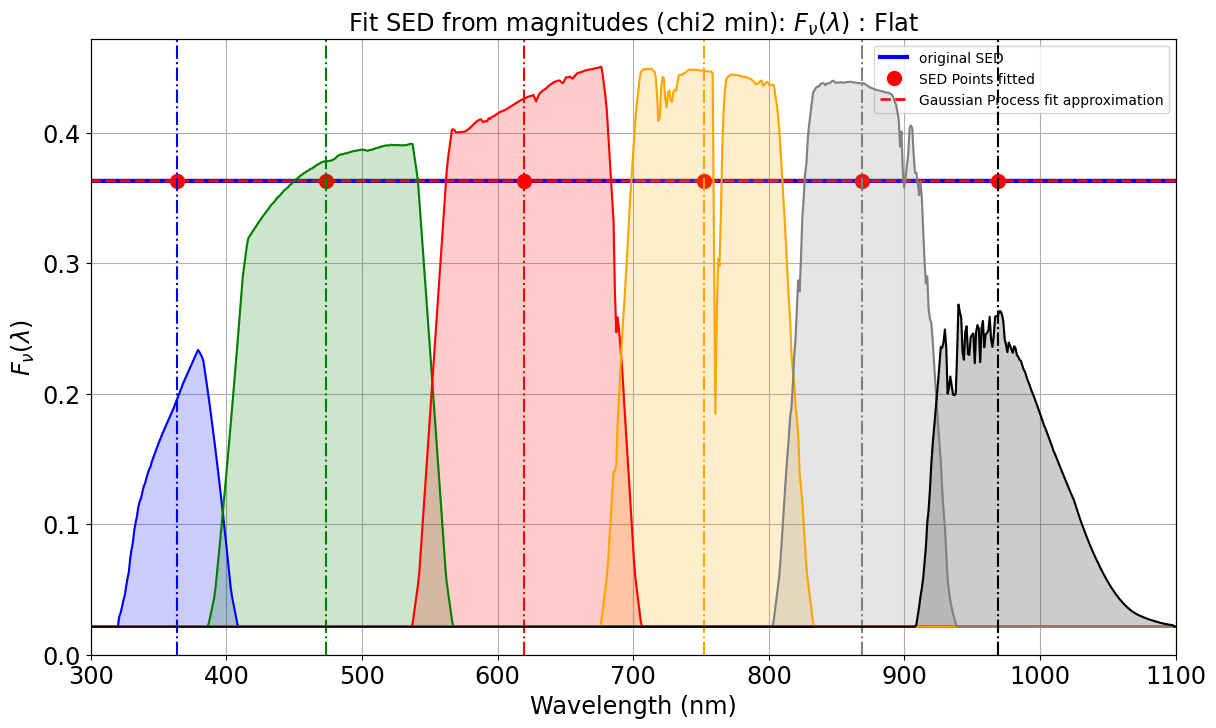

In [62]:
for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    the_sed_name = os.path.basename(the_sed.name)
    wavel,fnu = the_sed.get_sed_fnu()

    # compute the magnitudes for that SED
    mag_true = {}
    for index,f in enumerate(filter_tagnames):
        mag_true[f] = the_sed.calc_mag(pc.bandpass_total_std[f])

    # fit the SED points
    xdata = wl0
    ydata = mag_true
    ydataerr = mag_true_err
    res_fit,fit_dict = the_fit.fit(params0 = params0 ,bounds = bounds,xdata = xdata ,ydata = mag_true ,yerrdata=ydataerr,wlrange=wavel)

    
    # does the gaussian process fit from the fitted SED
    yfit = FitGaussianProcess(wl0,fit_dict["popt"],wlfit=wavel)
    

    
    # plot
    fig, ax = plt.subplots(1,1,figsize=(14,8))

    ax.plot(wavel,fnu,'b-',lw=3,label="original SED")
    ax.plot(wl0,fit_dict["popt"],marker="o",color="r",ms=10,lw=0,label="SED Points fitted")
    ax.plot(wavel,yfit,'r--',lw=2,label="Gaussian Process fit approximation")


    ax.grid()
    ax.set_xlim(300, 1100)
    ymin=0
    ymax = fit_dict["popt"].max()*1.3
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("$F_\\nu (\lambda)$")
    ax.set_title("Fit SED from magnitudes (chi2 min): $F_\\nu (\lambda)$"+ f" : {the_sed_name}")
    ax.legend(loc="upper right")


    ax2 = ax.twinx()

    for index,f in enumerate(filter_tagnames):
    
        ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
        ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
        ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
        ax2.set_yticks([])

    plt.show()